In [1181]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp
from lifelines import KaplanMeierFitter
from lifelines.plotting import add_at_risk_counts
from matplotlib_venn import venn2
from venn import venn

sns.set_palette('colorblind')
sns.set_style('white') 
palette = sns.color_palette('colorblind', 6)

In [1182]:
# Create dictionary to map gene ID to gene name
df = pd.read_csv('/Users/tk/Desktop/Research-CITS5014/Raw_gene_count/0a9e33db-2527-4cc3-8669-a7c10fed7a7f.rna_seq.augmented_star_gene_counts.tsv', delimiter='\t', header=1)
df = df.iloc[4:]
gene_id_to_name = dict(zip(df['gene_id'], df['gene_name']))

In [1183]:
df_with_subtype = pd.read_csv('/Users/tk/Desktop/gene_project/norm_pam50.csv', sep=',', index_col=0)
df_with_subtype.index.name = None

# Get survival time, status, and subtype from the dataframe
survival_time = pd.to_numeric(df_with_subtype.iloc[-3].values, errors='coerce')
status = pd.to_numeric(df_with_subtype.iloc[-2].values, errors='coerce')
subtypes = df_with_subtype.iloc[-1].values

/var/folders/nn/n9lqp7fs1pq402h_v1c984h40000gn/T/ipykernel_18355/3159216698.py:1: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251

### Use all samples to find optimal gene expression

In [1184]:
def plot_distribution(list, real_val, gene, p_val):
    plt.figure(figsize=(6, 4))
    obs_color = palette[2]
    # min_color = palette[1]
    # max_color = palette[3]
    # Calculate min and max values
    # min = np.min(list)
    # max = np.max(list)
    # Plot histogram with KDE
    sns.histplot(list, bins=60, kde=True, edgecolor='black')
    plt.axvline(real_val, color=obs_color, linestyle='--', label=f'Observed KS statistic: {real_val:.4f}', linewidth=2) 
    # plt.axvline(min, color=min_color, linestyle='--', label=f'Min simulated KS statistic: {min:.4f}', linewidth=2)
    # plt.axvline(max, color=max_color, linestyle='--', label=f'Max simulated KS statistic: {max:.4f}', linewidth=2) 
    text = f'KS Statistic Bootstrapped Null Distribution \n Gene: {gene_id_to_name.get(gene, gene)} (p = {p_val})' 
    plt.title(f'{text}', fontsize=10)
    plt.xlabel('KS statistic')
    plt.ylabel('Frequency')
    plt.legend(fontsize=8)
    plt.grid()
    plt.show()

def bootstrap_test(survival_time, real_ks, num_simulation=1000):
    ks_stats_sim = []
    
    for _ in range(num_simulation):   
        # Select a random split index
        split_index = np.random.randint(1, len(survival_time)//2)

        # Shuffle the data
        shuffled_data = survival_time.copy()
        np.random.shuffle(shuffled_data)

        # Divide the data based on the split index
        group1 = shuffled_data[:split_index]
        group2 = shuffled_data[split_index:]

        # Calculate Dictance
        ks_stat_sim, _ = ks_2samp(group1, group2)
        ks_stats_sim.append(ks_stat_sim)
    
    # Performing a one-sided test
    extreme_count = np.sum(np.array(ks_stats_sim) > real_ks)
    p_value = extreme_count / len(ks_stats_sim)

    # Plot simulation distribution
    # plot_distribution(ks_stats_sim, real_ks, gene, p_value.round(6))
    
    return ks_stats_sim, p_value.round(6)

In [1185]:
# Read and sort the result by high ks_statistic
ks_result = pd.read_csv(f'./result3/ks_All.csv', sep=',')
ks_result = ks_result[ks_result[f'ks_statistic_All'] != -np.inf]
ks_result

,gene,threshold_All,pvalue_All,ks_statistic_All,size_le,size_he
0,ENSG00000000003.15,0.014024,0.4321,0.0733,172.0,653.0
1,ENSG00000000005.6,0.000025,0.5868,0.0640,180.0,645.0
2,ENSG00000000419.13,0.004873,0.0533,0.9745,1.0,824.0
3,ENSG00000000457.14,0.001044,0.0436,0.9794,1.0,824.0
4,ENSG00000000460.17,0.000829,0.0436,0.9794,1.0,824.0
...,...,...,...,...,...,...
60654,ENSG00000288667.1,0.000004,0.5418,0.0831,724.0,101.0
60655,ENSG00000288669.1,0.000022,0.7134,0.2304,817.0,8.0
60656,ENSG00000288670.1,0.002675,0.6493,0.0571,216.0,609.0
60658,ENSG00000288674.1,0.000060,0.0834,0.0868,389.0,436.0


In [1186]:
# Filter result with p-value
filtered_df = ks_result[ks_result['pvalue_All'] <= 0.01].sort_values(by=f'pvalue_All')
filtered_df

,gene,threshold_All,pvalue_All,ks_statistic_All,size_le,size_he
17884,ENSG00000198824.7,0.002501,0.0000,0.9769,3.0,822.0
3838,ENSG00000111011.18,0.012226,0.0000,0.9769,3.0,822.0
52177,ENSG00000273174.1,0.000030,0.0000,0.9403,4.0,821.0
4505,ENSG00000115946.8,0.006066,0.0000,0.9769,3.0,822.0
11805,ENSG00000166266.14,0.004289,0.0000,0.9769,3.0,822.0
...,...,...,...,...,...,...
17734,ENSG00000198435.4,0.042768,0.0098,0.6720,820.0,5.0
29752,ENSG00000230882.1,0.000018,0.0098,0.4533,12.0,813.0
14878,ENSG00000180537.13,0.010339,0.0099,0.4086,810.0,15.0
29787,ENSG00000230943.3,0.000075,0.0099,0.1930,76.0,749.0


In [1187]:
# Get top gene lists
gene_list_All = filtered_df.iloc[:, 0].to_list()
len(gene_list_All)

1305

In [1188]:
# Calculate bootstrap p-value for top genes
km_df = filtered_df.copy()
num_simulation = 5000
for gene in gene_list_All:
    ks_obs = filtered_df.loc[filtered_df['gene'] == gene, 'ks_statistic_All'].iloc[0]
    ks_stats_sim, p_value = bootstrap_test(survival_time, ks_obs, num_simulation)
    km_df.loc[km_df['gene'] == gene, 'bootstrap_p'] = p_value

In [1189]:
# Filter result with p-value
km_df = km_df[km_df['bootstrap_p'] <= 0.001]
km_df

,gene,threshold_All,pvalue_All,ks_statistic_All,size_le,size_he,bootstrap_p
17884,ENSG00000198824.7,0.002501,0.0000,0.9769,3.0,822.0,0.0000
3838,ENSG00000111011.18,0.012226,0.0000,0.9769,3.0,822.0,0.0000
52177,ENSG00000273174.1,0.000030,0.0000,0.9403,4.0,821.0,0.0002
4505,ENSG00000115946.8,0.006066,0.0000,0.9769,3.0,822.0,0.0000
11805,ENSG00000166266.14,0.004289,0.0000,0.9769,3.0,822.0,0.0002
...,...,...,...,...,...,...,...
28966,ENSG00000229765.2,0.000229,0.0097,0.9964,824.0,1.0,0.0000
10247,ENSG00000158710.15,0.931642,0.0098,0.6720,820.0,5.0,0.0004
8104,ENSG00000141433.13,0.052062,0.0098,0.6720,820.0,5.0,0.0002
11184,ENSG00000163950.13,0.093424,0.0098,0.6720,820.0,5.0,0.0000


In [1192]:
# Get top gene lists
gene_list_All = km_df.iloc[:, 0].to_list()
for gene in gene_list_All:
    print(gene_id_to_name.get(gene, gene))

CHAMP1
RSRC2
AC108673.2
PNO1
CUL5
SPG11
CNST
LRIF1
CCNT1
BRI3BP
BLOC1S6
TGDS
DDX18
SLC22A4
C5orf22
SAP130
GPATCH8
UBE3A
LGALS8
EAF1
RAB11FIP2
FKTN
DPP8
IARS2
FUBP3
STX3
PIGB
RFX7
MDM2
EXOC6
AKAP10
PRDX3
CD46
CCNG2
ADIPOR2
RNF34
PDE12
DENND10
AL360270.1
BRMS1L
RBM12
KIF3A
MAPRE1
CSNK1G1
TBK1
FBXW2
RIC8B
RPAP3
LEMD3
PLEKHO1
HAUS8
DSG1
HSPA2
FAM136A
ATOH7
UBE2L3
NDUFA6
PIH1D1
FAM177A1
HSPA6
HNRNPA3
AC063960.1
AL162588.1
RPL36
STX10
AOPEP
GOT1
OR7E36P
ATG3
SMIM4
SH3BGRL2
SNX22
NBEA
PHF19
SPECC1L
AMIGO1
MGAT4A
POF1B
NFIA
C19orf38
INPP5J
FBXO33
PPIB
HCP5
PCGF2
RPS18P9
GINS3
ARL13B
SIN3A
BAG5
NUP50
PCNX4
PAPOLA
RAB2B
ZSCAN29
TTBK2
TRPM7
MIS18BP1
SUPT20H
SERPINI1
RNF144B
PHF12
SOCS4
HMGXB4
ATP6V1B2
ZC3H12A
TNRC6B
LATS2
NCOA6
FBXO34
PCNX1
ZNF609
GMFB
PAXIP1-AS2
MIDEAS
GSTM4
PPP2R5C
STAU1
RREB1
NUMB
STRN3
BAZ2A
TRIM69
NAA30
ITCH
SP3
TCF12
SGSM1
EXOC5
TXNDC9
BUB3
CBARP
TBKBP1
AL353596.1
SBK1
THAP7
FAM162B
DDX39A
ZNF570
LINC01742
CRELD2
AP001005.1
TRMU
ACTG1P25
HSP90B1
GDF9
KRR1
TDG
PDS5A
UBE2N
ME

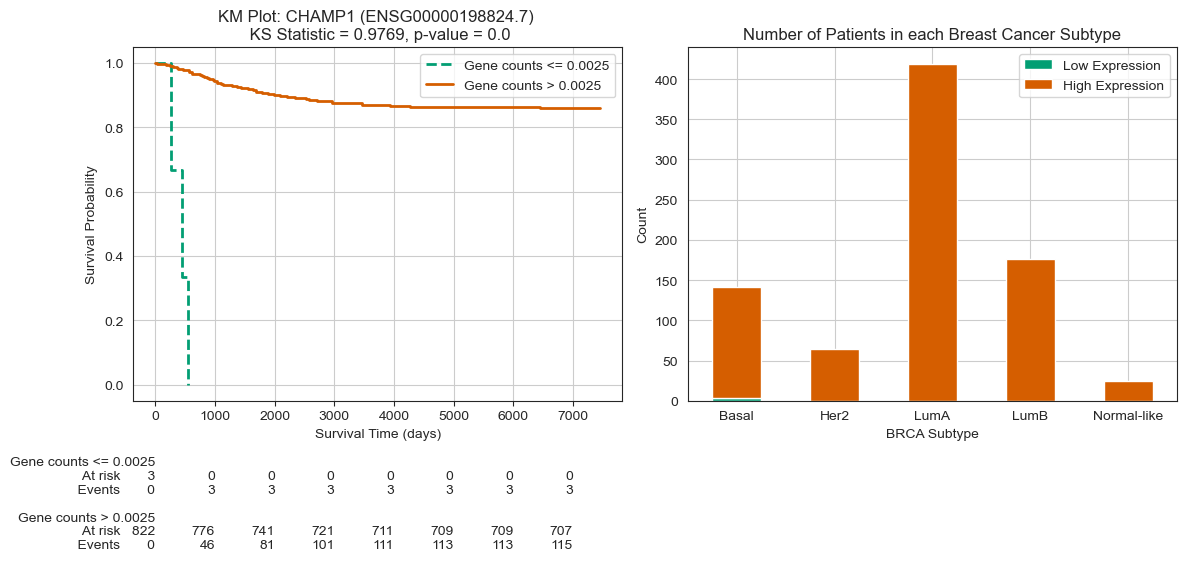

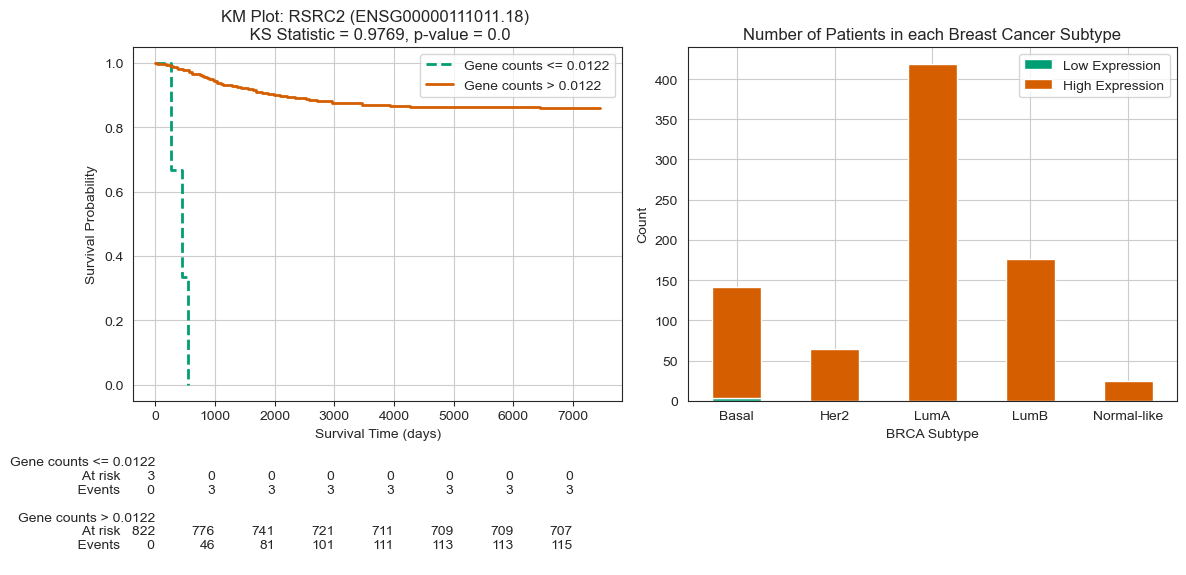

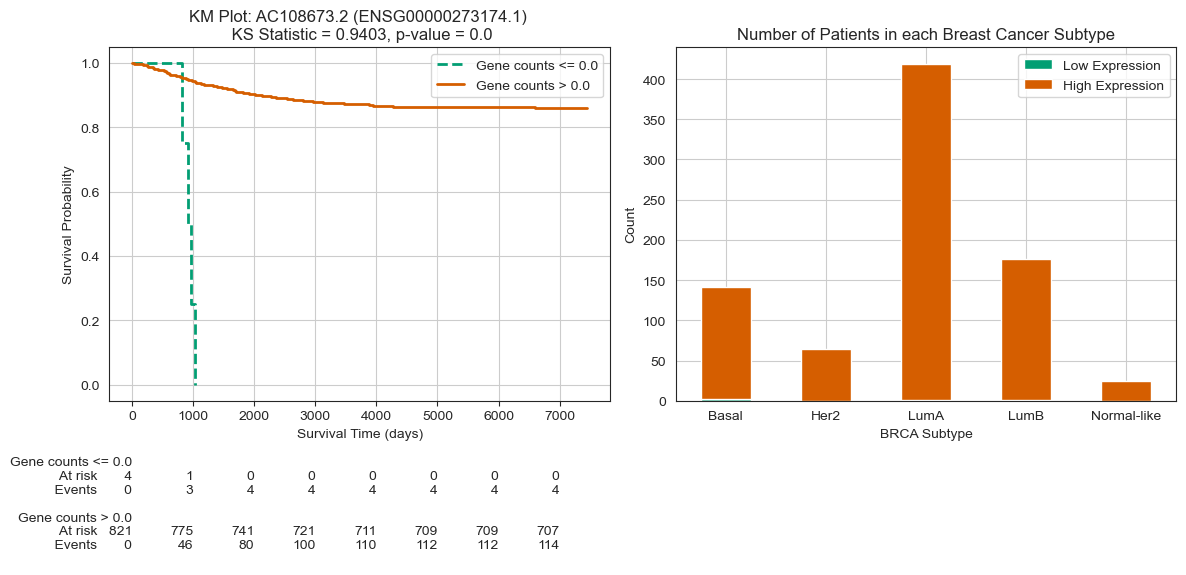

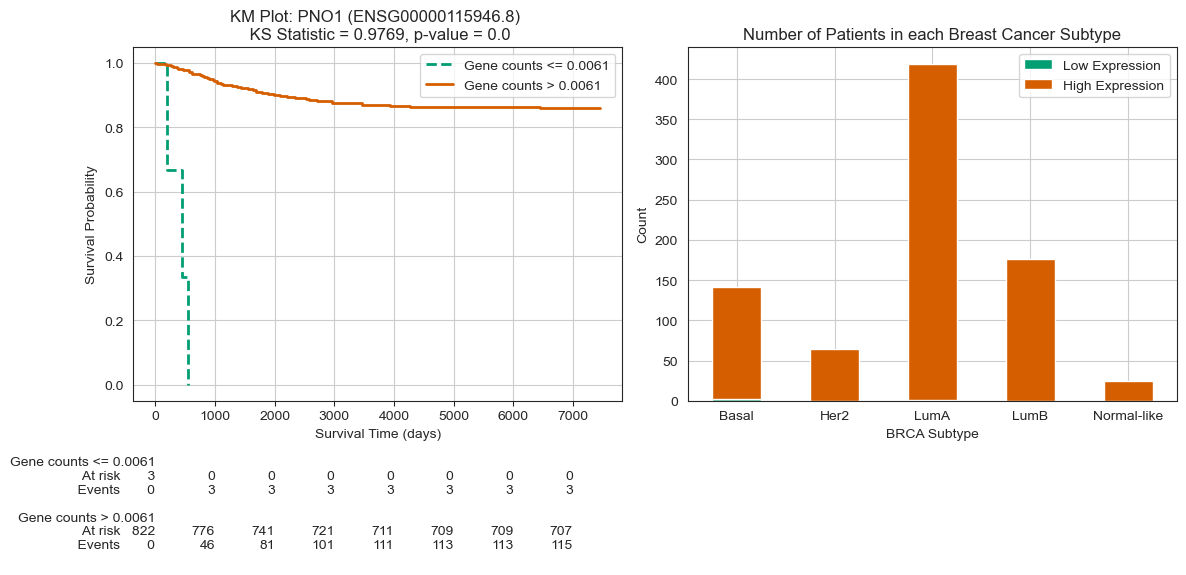

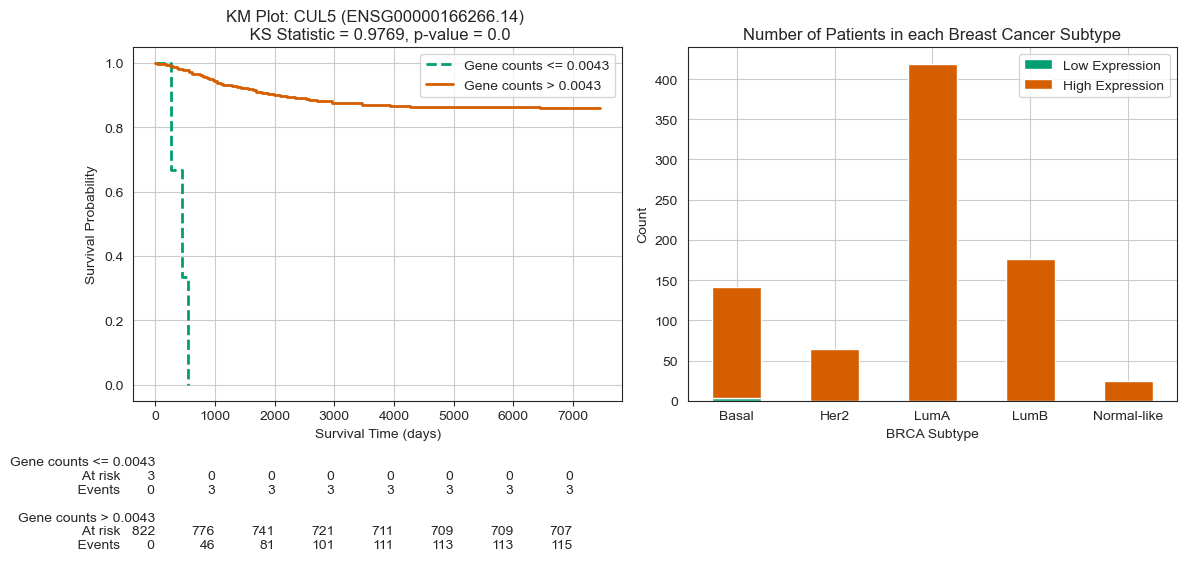

In [1193]:
# Plot KM Curves
for i, gene in enumerate(gene_list_All[:5]):

    # Get gene count of that gene
    row = pd.to_numeric(df_with_subtype.loc[gene].values, errors='coerce')
    # Find the median value
    # optimal_threshold = np.median(row)
    # print(median_value)

    # Get optimal threshold for that gene
    tbl = ks_result[ks_result['gene'] == gene]
    optimal_threshold = pd.to_numeric(tbl['threshold_All'].values[0], errors='coerce')

    # Extract days to death
    time_g1 = survival_time[row <= optimal_threshold]
    time_g2 = survival_time[row > optimal_threshold]
    
    # Extract status
    status_g1 = status[row <= optimal_threshold]
    status_g2 = status[row > optimal_threshold]

    data_g1 = pd.DataFrame({
        'survival_time': time_g1,
        'group': 'Low Expression',
        'event_occurred': status_g1})

    data_g2 = pd.DataFrame({
    'survival_time': time_g2,
    'group': 'HighExpression',
    'event_occurred': status_g2})

    data = pd.concat([data_g1, data_g2], axis=0, ignore_index=True)

    # Extract KS_statistics
    ks_stat = round(tbl['ks_statistic_All'].values[0], 4)
    ks_pval = round(tbl['pvalue_All'].values[0], 4)
    # ks_stat, ks_pval = ks_2samp(time_g1, time_g2)
    text = f"KS Statistic = {round(ks_stat, 4)}, p-value = {round(ks_pval, 4)}"

    # print("Calculated KS", ks_2samp(time_g1, time_g2))

    # Fit KaplanMeierFitter
    kmf_1 = KaplanMeierFitter()
    kmf_2 = KaplanMeierFitter()
    kmf_1.fit(data_g1['survival_time'], data_g1['event_occurred'], label=f"Gene counts <= {round(optimal_threshold, 4)}")
    kmf_2.fit(data_g2['survival_time'], data_g2['event_occurred'], label=f"Gene counts > {round(optimal_threshold, 4)}")

    # Plot Kaplan-Meier survival functions
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Top subplot
    ax = axs[0]
    kmf_1.plot_survival_function(ax=ax, ci_show=False, linestyle='dashed', linewidth=2, color=sns.color_palette('colorblind')[2])
    kmf_2.plot_survival_function(ax=ax, ci_show=False, linestyle='solid', linewidth=2, color=sns.color_palette('colorblind')[3])
    add_at_risk_counts(kmf_1, kmf_2, ax=ax, rows_to_show=['At risk', 'Events'])

    # Perform Log-rank test
    # logrank_results = logrank_test(time_g1, time_g2, event_observed_A=status_g1, event_observed_B=status_g2)
    # plt.text(0.6, 0.4, 
    # f'Log-rank p-value = {logrank_results.p_value:.4f}', 
    # transform=ax.transAxes, 
    # fontsize=11, color='blue', 
    # style='italic', 
    # )

    # # Perform Wilcoxon (Gehan-Breslow) test
    # wilcoxon_results = multivariate_logrank_test(data['survival_time'], data['group'], data['event_occurred'], weightings="wilcoxon")
    # plt.text(0.6, 0.35, 
    # f'Wilcoxon p-value = {wilcoxon_results.p_value:.4f}', 
    # transform=ax.transAxes, 
    # fontsize=11, color='blue', 
    # style='italic', 
    # )

    ax.set_title(f"KM Plot: {gene_id_to_name.get(gene, gene)} ({gene}) \n {text}")
    ax.set_xlabel("Survival Time (days)")
    ax.set_ylabel("Survival Probability")
    ax.grid(True)
    ax.legend()
    
    ###########
    # Extract subtypes
    type_g1 = subtypes[row <= optimal_threshold]
    type_g2 = subtypes[row > optimal_threshold]

    # Count occurrences of each unique type
    unique_values = np.unique(np.concatenate([type_g1, type_g2]))

    # Count occurrences for each unique value in result1 and result2
    counts_result1 = np.array([np.count_nonzero(type_g1 == val) for val in unique_values])
    counts_result2 = np.array([np.count_nonzero(type_g2 == val) for val in unique_values])

    # Create a DataFrame directly
    df = pd.DataFrame({
        'Count': unique_values,
        'Low Expression': counts_result1,
        'High Expression': counts_result2
    }).set_index('Count')

    # Normalize the DataFrame to get proportions
    df_normalized = df.div(df.sum(axis=1), axis=0)

    # Bottom subplot
    ax = axs[1]
    # df.plot(kind='barh', stacked=True, color=[palette[2], palette[3]], ax=ax)
    # df_normalized.plot(kind='bar', stacked=True, color=[palette[2], palette[3]], ax=ax)
    df.plot(kind='bar', stacked=True, color=[palette[2], palette[3]], ax=ax)
    ax.set_xlabel('BRCA Subtype')
    ax.set_xticklabels(df.index, rotation=0)
    ax.set_ylabel('Count')
    ax.set_title('Number of Patients in each Breast Cancer Subtype')
    ax.legend()
    ax.grid()
    plt.tight_layout()
    plt.show()

In [ ]:
# Check PH assumptions
for i, gene in enumerate(gene_list_All[:1]):

    # Get gene count of that gene
    row = pd.to_numeric(df_with_subtype.loc[gene].values, errors='coerce')
    # Find the median value
    # optimal_threshold = np.median(row)
    # print(median_value)

    # Get optimal threshold for that gene
    tbl = ks_result[ks_result['gene'] == gene]
    optimal_threshold = pd.to_numeric(tbl['threshold_All'].values[0], errors='coerce')

    # Extract days to death
    time_g1 = survival_time[row <= optimal_threshold]
    time_g2 = survival_time[row > optimal_threshold]
    
    # Extract status
    status_g1 = status[row <= optimal_threshold]
    status_g2 = status[row > optimal_threshold]

    # Combine data into a DataFrame
    data = pd.DataFrame({
        'time': np.concatenate((time_g1, time_g2)),
        'event': np.concatenate((status_g1, status_g2)),
        'group': ['Low Expression'] * len(time_g1) + ['High Expression'] * len(time_g2)})

    # Step 2: Create a single plot
    plt.figure(figsize=(10, 6))

    # Step 3: Fit Kaplan-Meier Curves and Calculate -log(-log(S(t))) for Each Group
    for name, grouped_df in data.groupby('group'):
        kmf = KaplanMeierFitter()
        kmf.fit(grouped_df['time'], event_observed=grouped_df['event'])
        
        # Calculate S(t)
        survival_function = kmf.survival_function_

        # Compute -log(-log(S(t)))
        epsilon = 1e-10
        log_neg_log_S = -np.log(-np.log(survival_function + epsilon))

        # Plot
        plt.plot(survival_function.index, log_neg_log_S, label=f'-log(-log(S(t))) for {name}')

    # Step 4: Configure Plot
    plt.title('Plot of -log(-log(S(t))) for Each Group')
    plt.xlabel('Time')
    plt.ylabel('-log(-log(S(t)))')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

In [ ]:
# boxplot_data = []
# for gene in gene_list_All[:1]:
#     # Get gene count
#     row = pd.to_numeric(df_with_subtype.loc[gene].values, errors='coerce')
#     # Get optimal threshold for that gene
#     tbl = ks_result[ks_result['gene'] == gene]
#     optimal_threshold = pd.to_numeric(tbl['threshold_All'].values[0], errors='coerce')
    
#     # Split time, status based on current threshold
#     time_g1 = survival_time[row <= optimal_threshold]
#     time_g2 = survival_time[row > optimal_threshold]

#     # Append the gene, means, and group sizes as a list to result
#     boxplot_data.append([gene_id_to_name.get(gene, gene), list(time_g1), list(time_g2)])

# # Convert result into a DataFrame
# boxplot_data = pd.DataFrame(boxplot_data, columns=['gene', 'time_le', 'time_he'])

# # Convert the lists from 'time_le' and 'time_he' columns into a long format DataFrame
# df_long = pd.DataFrame({
#     'gene': boxplot_data['gene'].repeat(boxplot_data['time_le'].apply(len) + boxplot_data['time_he'].apply(len)),
#     'time': sum(boxplot_data['time_le'].tolist(), []) + sum(boxplot_data['time_he'].tolist(), []),
#     'group': ['Low Expression'] * sum(boxplot_data['time_le'].apply(len)) + ['High Expression'] * sum(boxplot_data['time_he'].apply(len))
# })

# plt.figure(figsize=(6, 6))
# # Create the violin plot
# sns.violinplot(x='gene', y='time', hue='group', data=df_long,
#                palette={'Low Expression': palette[2], 'High Expression': palette[3]},
#                split=True, inner='quartile', linewidth=1.2)
# plt.title('Survival Time Distribution')
# plt.xlabel('')
# plt.ylabel('Survival Time (days)')
# plt.legend(title='Group', loc='upper right')
# plt.grid(True, linestyle='--', alpha=0.7)
# plt.tight_layout()
# plt.show()

#### Imbalanced group

In [550]:
# Filter result with 1 person in a group
x = 823
imbalanced_df = ks_result[ks_result['pvalue_All'] <= 0.05].sort_values(by=f'pvalue_All')
imbalanced_df = ks_result[abs(ks_result['size_le'] - ks_result['size_he']) == x]
imbalanced_df = imbalanced_df[imbalanced_df['pvalue_All'] <= 0.05]
imbalanced_df

,gene,threshold_All,pvalue_All,ks_statistic_All,size_le,size_he
3,ENSG00000000457.14,0.001044,0.0436,0.9794,1.0,824.0
4,ENSG00000000460.17,0.000829,0.0436,0.9794,1.0,824.0
8,ENSG00000001084.13,0.003264,0.0436,0.9794,1.0,824.0
9,ENSG00000001167.14,0.004559,0.0436,0.9794,1.0,824.0
13,ENSG00000001561.7,0.000391,0.0436,0.9794,1.0,824.0
...,...,...,...,...,...,...
60384,ENSG00000287998.1,0.002643,0.0218,0.9903,824.0,1.0
60391,ENSG00000288005.1,0.001167,0.0388,0.9818,824.0,1.0
60459,ENSG00000288075.1,0.000000,0.0194,0.9915,1.0,824.0
60519,ENSG00000288330.1,0.000432,0.0461,0.9782,824.0,1.0


In [551]:
imbalanced_list = imbalanced_df.iloc[:, 0].to_list()
sample_id = df_with_subtype.columns

In [552]:
samples_dict = {}
for i, gene in enumerate(imbalanced_list):
    # Get gene count of that gene
    row = pd.to_numeric(df_with_subtype.loc[gene].values, errors='coerce')

    # Get optimal threshold for that gene
    tbl = imbalanced_df[imbalanced_df['gene'] == gene]
    optimal_threshold = pd.to_numeric(tbl['threshold_All'].values[0], errors='coerce')

    # Split samples based on the optimal threshold
    sample_g1 = sample_id[row <= optimal_threshold]
    sample_g2 = sample_id[row > optimal_threshold]

    # Store either sample_g1 or sample_g2 in the dictionary
    if len(sample_g1) == 1:
        samples_dict[gene] = sample_g1[0]  # Store the single sample from sample_g1
    elif len(sample_g2) == 1:
        samples_dict[gene] = sample_g2[0]  # Store the single sample from sample_g2

# Print the length of the dictionary
print(len(samples_dict))

2007


In [553]:
sample_list = list(samples_dict.values())
sample_list = pd.Series(sample_list)
counts = sample_list.value_counts()
counts

TCGA-AC-A2QJ-01A    1147
TCGA-A2-A0T2-01A     256
TCGA-BH-A18T-01A     128
TCGA-E2-A1LK-01A     119
TCGA-BH-A18N-01A      91
TCGA-D8-A1XC-01A      70
TCGA-A8-A08L-01A      36
TCGA-BH-A1F8-01A      20
TCGA-BH-A1EV-01A      18
TCGA-AC-A3EH-01A      17
TCGA-C8-A12Q-01A      15
TCGA-A8-A09X-01A      15
TCGA-AQ-A0Y5-01A      14
TCGA-BH-A42T-01A      12
TCGA-EW-A1P8-01A      11
TCGA-AR-A1AR-01A      11
TCGA-A2-A0CU-01A      10
TCGA-B6-A0I9-01A       9
TCGA-E2-A15M-01A       7
TCGA-D8-A1Y1-01A       1
Name: count, dtype: int64

In [554]:
# Read survival time data
clinical = pd.read_csv('/Users/tk/Desktop/Research-CITS5014/GDC_Data/clinical.project-tcga-brca.2024-03-19/clinical.tsv', delimiter='\t')

# Each case_submitter_id has 2 records
clinical = clinical.drop_duplicates(subset='case_submitter_id')
clinical.head()

,case_id,case_submitter_id,project_id,age_at_index,age_is_obfuscated,cause_of_death,cause_of_death_source,country_of_residence_at_enrollment,days_to_birth,days_to_death,...,treatment_arm,treatment_dose,treatment_dose_units,treatment_effect,treatment_effect_indicator,treatment_frequency,treatment_intent_type,treatment_or_therapy,treatment_outcome,treatment_type
0,001cef41-ff86-4d3f-a140-a647ac4b10a1,TCGA-E2-A1IU,TCGA-BRCA,60,'--,'--,'--,'--,-22279,'--,...,'--,'--,'--,'--,'--,'--,'--,no,'--,"Radiation Therapy, NOS"
2,0045349c-69d9-4306-a403-c9c1fa836644,TCGA-A1-A0SB,TCGA-BRCA,70,'--,'--,'--,'--,-25833,'--,...,'--,'--,'--,'--,'--,'--,'--,not reported,'--,"Radiation Therapy, NOS"
4,00807dae-9f4a-4fd1-aac2-82eb11bf2afb,TCGA-A2-A04W,TCGA-BRCA,50,'--,'--,'--,'--,-18345,'--,...,'--,'--,'--,'--,'--,'--,'--,no,'--,"Radiation Therapy, NOS"
6,00a2d166-78c9-4687-a195-3d6315c27574,TCGA-AN-A0AM,TCGA-BRCA,56,'--,'--,'--,'--,-20713,'--,...,'--,'--,'--,'--,'--,'--,'--,no,'--,"Pharmaceutical Therapy, NOS"
8,00b11ca8-8540-4a3d-b602-ec754b00230b,TCGA-LL-A440,TCGA-BRCA,61,'--,'--,'--,'--,-22497,'--,...,'--,'--,'--,'--,'--,'--,'--,yes,'--,"Pharmaceutical Therapy, NOS"


In [555]:
# Remove '-01A' from each element in the list
case_submitter_id_list = [item.replace('-01A', '') for item in sample_list]
imbalanced_clinical = clinical[clinical['case_submitter_id'].isin(case_submitter_id_list)]
imbalanced_clinical

,case_id,case_submitter_id,project_id,age_at_index,age_is_obfuscated,cause_of_death,cause_of_death_source,country_of_residence_at_enrollment,days_to_birth,days_to_death,...,treatment_arm,treatment_dose,treatment_dose_units,treatment_effect,treatment_effect_indicator,treatment_frequency,treatment_intent_type,treatment_or_therapy,treatment_outcome,treatment_type
148,10c829ec-fd66-49c4-8afe-ad3ae567372c,TCGA-BH-A42T,TCGA-BRCA,75,'--,'--,'--,'--,-27731,320,...,'--,'--,'--,'--,'--,'--,'--,no,'--,"Radiation Therapy, NOS"
166,128d198e-9b22-427c-90db-3714455f3a17,TCGA-A2-A0T2,TCGA-BRCA,66,'--,'--,'--,'--,-24235,255,...,'--,'--,'--,'--,'--,'--,'--,no,'--,"Radiation Therapy, NOS"
252,1d27253f-b036-44e7-a04d-8da5bbf57419,TCGA-E2-A1LK,TCGA-BRCA,84,'--,'--,'--,'--,-30757,266,...,'--,'--,'--,'--,'--,'--,'--,no,'--,"Pharmaceutical Therapy, NOS"
328,27b05b15-a44b-45ed-a6e3-e7d1ca488ea9,TCGA-A8-A09X,TCGA-BRCA,62,'--,'--,'--,'--,-22858,426,...,'--,'--,'--,'--,'--,'--,'--,not reported,'--,"Radiation Therapy, NOS"
410,30ec8b1f-28c4-4f46-8a1b-a8d51e558c7d,TCGA-BH-A18T,TCGA-BRCA,70,'--,'--,'--,'--,-25674,224,...,'--,'--,'--,'--,'--,'--,'--,not reported,'--,"Pharmaceutical Therapy, NOS"
436,332423a7-8866-4ee3-b08f-3c8d7c16af80,TCGA-A2-A0CU,TCGA-BRCA,73,'--,'--,'--,'--,-26823,158,...,'--,'--,'--,'--,'--,'--,'--,no,'--,"Radiation Therapy, NOS"
456,359f12f9-5c41-48a4-85bc-fd7e307bf7d8,TCGA-EW-A1P8,TCGA-BRCA,58,'--,'--,'--,'--,-21501,239,...,'--,'--,'--,'--,'--,'--,'--,yes,'--,"Pharmaceutical Therapy, NOS"
486,38a631a1-6875-4216-a335-ee93c90a86d6,TCGA-D8-A1Y1,TCGA-BRCA,80,'--,'--,'--,'--,-29474,302,...,'--,'--,'--,'--,'--,'--,'--,no,'--,"Radiation Therapy, NOS"
562,417dea5f-f68e-4dab-940e-43ae8c67e5e6,TCGA-BH-A1EV,TCGA-BRCA,45,'--,'--,'--,'--,-16504,365,...,'--,'--,'--,'--,'--,'--,'--,no,'--,"Pharmaceutical Therapy, NOS"
594,44954053-0b93-4577-a436-42777e442300,TCGA-B6-A0I9,TCGA-BRCA,62,'--,'--,'--,'--,-22798,362,...,'--,'--,'--,'--,'--,'--,'--,yes,'--,"Pharmaceutical Therapy, NOS"


### Intersection

In [1194]:
# Read KS-test results
list_of_mins = ['01', '10', '20', '30', '40']
top_genes = {}
df_dict = {}

for min_value in list_of_mins:
    ks_result = pd.read_csv(f'./result2/ot_all_ks_{min_value}.csv', sep=',')
    ks_result = ks_result[ks_result['ks_statistic'] != -np.inf]
    ks_result = ks_result[ks_result['pvalue'] <= 0.01].sort_values(by=f'pvalue')
    # Store the DataFrame
    df_dict[f'ks_result_{min_value}'] = ks_result
    # Extract top genes and convert to set
    top_genes[f'top_gene_ks_{min_value}'] = set(ks_result.iloc[:, 0])
    
    # Print the number of top genes for each dataset
    print(f"Number of top genes in ks_result_{min_value}: {len(top_genes[f'top_gene_ks_{min_value}'])}")

Number of top genes in ks_result_01: 257
Number of top genes in ks_result_10: 93
Number of top genes in ks_result_20: 38
Number of top genes in ks_result_30: 16
Number of top genes in ks_result_40: 12


In [1195]:
# Compute the intersection of all sets
sets = top_genes.values()
if sets:  # Check if there are any sets to intersect
    intersection = set.intersection(*sets)
    print("Number of intersection top genes:", len(intersection))
    intersection_list = list(intersection)
    comparison_df = pd.DataFrame(index=intersection_list, columns=list_of_mins)
    
    # Store optimal threshold for each top gene
    for gene in intersection_list:
        for min_value in list_of_mins:
            ks_result = df_dict[f'ks_result_{min_value}']
            gene_row = ks_result[ks_result.iloc[:, 0] == gene]
            if not gene_row.empty:
                comparison_df.loc[gene, min_value] = gene_row.iloc[0, 3]  # Compare KS statistic column

    # Calculate statistics
    comparison_df = comparison_df.apply(pd.to_numeric)
    comparison_df['Std Dev'] = comparison_df.std(axis=1)

Number of intersection top genes: 12


In [1196]:
comparison_df

,01,10,20,30,40,Std Dev
ENSG00000198133.8,0.1253,0.1253,0.1253,0.1253,0.1253,0.000000e+00
ENSG00000270547.6,0.1166,0.1166,0.1166,0.1166,0.1166,0.000000e+00
ENSG00000108312.15,0.1285,0.1285,0.1285,0.1285,0.1162,5.500727e-03
ENSG00000282951.1,0.1177,0.1177,0.1177,0.1177,0.1177,0.000000e+00
ENSG00000278831.1,0.1164,0.1164,0.1164,0.1164,0.1164,1.551584e-17
ENSG00000261664.5,0.1170,0.1170,0.1170,0.1170,0.1155,6.708204e-04
ENSG00000243738.3,0.1144,0.1144,0.1144,0.1144,0.1144,1.551584e-17
ENSG00000165887.12,0.1338,0.1338,0.1338,0.1338,0.1182,6.976532e-03
ENSG00000197249.14,0.1142,0.1142,0.1142,0.1142,0.1142,0.000000e+00
ENSG00000175920.18,0.1165,0.1165,0.1165,0.1165,0.1165,0.000000e+00


In [1197]:
intersection_list = comparison_df.index
for gene in intersection_list:
    print(gene_id_to_name.get(gene, gene))

TMEM229B
LINC01235
UBTF
AC008537.4
AL513190.1
TTC39A-AS1
RN7SL181P
ANKRD2
SERPINA1
DOK7
PLAT
TLN2


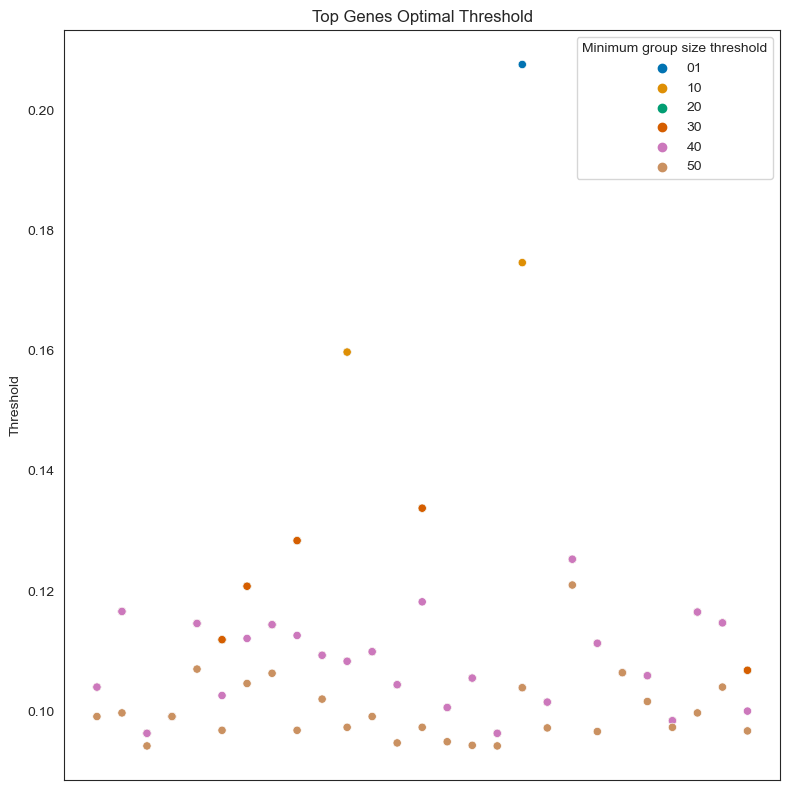

In [624]:
plot_df = comparison_df.drop(columns=['Std Dev'])
# Reset index to make 'Gene' a column
plot_df = plot_df.reset_index().rename(columns={'index': 'Gene'})
# Melt the DataFrame to long format
plot_df = plot_df.melt(id_vars=['Gene'], var_name='Min_group_size_threshold', value_name='Threshold')

plt.figure(figsize=(8, 8))
sns.scatterplot(data=plot_df, x='Gene', y='Threshold', hue='Min_group_size_threshold')
plt.xticks(rotation=90, fontsize=6)
plt.title('Top Genes Optimal Threshold')
plt.xlabel('Gene')
plt.ylabel('Threshold')
plt.legend(title='Minimum group size threshold')
# Hide the x-axis
plt.gca().xaxis.set_visible(False)
plt.tight_layout()
plt.show()

In [1198]:
# Select min group size threshold = 10% as a final result
ks_result = pd.read_csv(f'./result2/ot_all_ks_10.csv', sep=',')
ks_result = ks_result[ks_result['ks_statistic'] != -np.inf].sort_values(by='pvalue')
ks_result

,gene,threshold,pvalue,ks_statistic,size_le,size_he
8134,ENSG00000141552.18,0.017358,0.0004,0.2141,102.0,723.0
15675,ENSG00000184208.12,0.008042,0.0007,0.1888,129.0,696.0
15827,ENSG00000184887.13,0.015876,0.0009,0.2229,84.0,741.0
11968,ENSG00000166902.5,0.011181,0.0013,0.2141,87.0,738.0
436,ENSG00000023892.11,0.007084,0.0013,0.1662,161.0,664.0
...,...,...,...,...,...,...
30158,ENSG00000231505.1,0.000000,1.0000,0.0218,736.0,89.0
54185,ENSG00000277199.1,0.000000,1.0000,0.0194,697.0,128.0
52725,ENSG00000274258.1,0.000000,1.0000,0.0146,585.0,240.0
55756,ENSG00000279752.1,0.000000,1.0000,0.0240,728.0,97.0


In [1199]:
filtered_df = ks_result[ks_result['gene'].isin(intersection_list)]
filtered_df

,gene,threshold,pvalue,ks_statistic,size_le,size_he
11703,ENSG00000165887.12,0.000118,0.0017,0.1338,510.0,315.0
17651,ENSG00000198133.8,0.010991,0.0027,0.1253,405.0,420.0
3509,ENSG00000108312.15,0.071253,0.0036,0.1285,288.0,537.0
56698,ENSG00000282951.1,0.000101,0.0063,0.1177,371.0,454.0
13975,ENSG00000175920.18,0.001760,0.0070,0.1165,369.0,456.0
55013,ENSG00000278831.1,0.000068,0.0076,0.1164,352.0,473.0
50646,ENSG00000270547.6,0.001426,0.0078,0.1166,485.0,340.0
13174,ENSG00000171914.16,0.019551,0.0079,0.1146,415.0,410.0
46799,ENSG00000261664.5,0.000398,0.0085,0.1170,320.0,505.0
2910,ENSG00000104368.19,0.036658,0.0089,0.1147,352.0,473.0


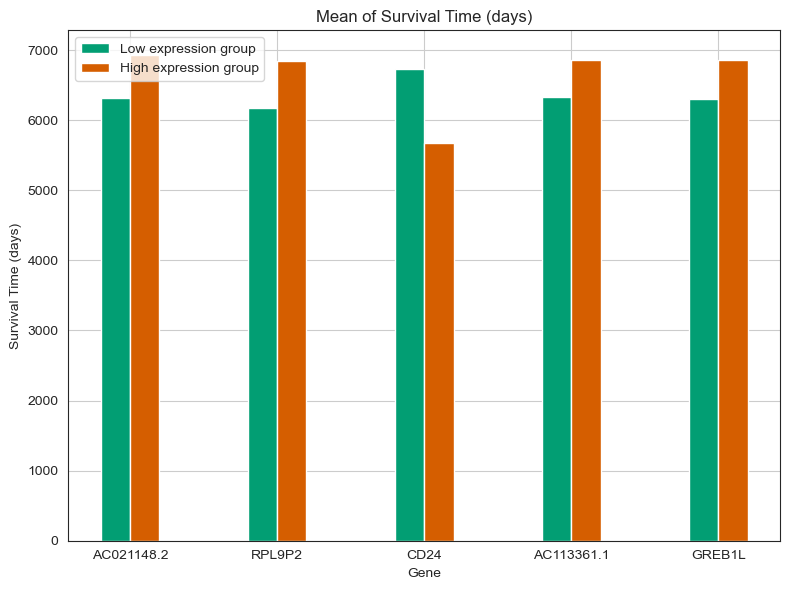

In [862]:
norm_count = pd.read_csv('./norm_PAM50.csv', low_memory=False)
norm_count.set_index(norm_count.columns[0], inplace=True)

# Get survival time, status, and subtype from the dataframe
survival_time = pd.to_numeric(norm_count.iloc[-3].values, errors='coerce')
status = pd.to_numeric(norm_count.iloc[-2].values, errors='coerce')
subtypes = norm_count.iloc[-1].values

mean_time = []
for gene in intersection_list[:5]:
    # Get gene count
    row = pd.to_numeric(norm_count.loc[gene].values, errors='coerce')
    # Get optimal threshold for that gene
    tbl = ks_result[ks_result['gene'] == gene]
    optimal_threshold = pd.to_numeric(tbl['threshold'].values[0], errors='coerce') 
    # Split time, status based on current threshold
    time_g1 = survival_time[row <= optimal_threshold]
    time_g2 = survival_time[row > optimal_threshold]
    size_le = len(time_g1)
    size_he = len(time_g2)
    mean_t1 = time_g1.mean()
    mean_t2 = time_g2.mean()
    # Append the gene, means, and group sizes as a list to result
    mean_time.append([gene_id_to_name.get(gene, gene), mean_t1, mean_t2, size_le, size_he])

# Convert result into a DataFrame
mean_time = pd.DataFrame(mean_time, columns=['gene', 'mean_time_le', 'mean_time_he', 'size_le', 'size_he'])

fig, ax = plt.subplots(figsize=(8, 6))
palette = sns.color_palette('colorblind', 6)

# Set the positions and width for the bars
bar_width = 0.2
index = range(len(mean_time))

# Plot bars for Mean_Time_G1
bars1 = ax.bar(index, mean_time['mean_time_le'], bar_width, label='Low expression group', color=palette[2])
# Plot bars for Mean_Time_G2
bars2 = ax.bar([i + bar_width for i in index], mean_time['mean_time_he'], bar_width, label='High expression group', color=palette[3])
ax.set_xlabel('Gene')
ax.set_ylabel('Survival Time (days)')
ax.set_title('Mean of Survival Time (days)')
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(mean_time['gene'], rotation=0)
ax.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

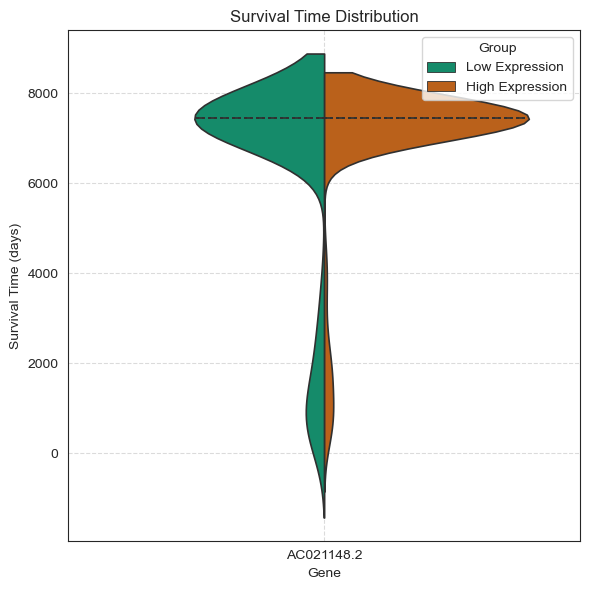

In [629]:
boxplot_data = []
for gene in intersection_list[:1]:
    # Get gene count
    row = pd.to_numeric(norm_count.loc[gene].values, errors='coerce')
    # Get optimal threshold for that gene
    tbl = ks_result[ks_result['gene'] == gene]
    optimal_threshold = pd.to_numeric(tbl['threshold'].values[0], errors='coerce')
    
    # Split time, status based on current threshold
    time_g1 = survival_time[row <= optimal_threshold]
    time_g2 = survival_time[row > optimal_threshold]

    # Append the gene, means, and group sizes as a list to result
    boxplot_data.append([gene_id_to_name.get(gene, gene), list(time_g1), list(time_g2)])

# Convert result into a DataFrame
boxplot_data = pd.DataFrame(boxplot_data, columns=['gene', 'time_le', 'time_he'])

# Convert the lists from 'time_le' and 'time_he' columns into a long format DataFrame
df_long = pd.DataFrame({
    'gene': boxplot_data['gene'].repeat(boxplot_data['time_le'].apply(len) + boxplot_data['time_he'].apply(len)),
    'time': sum(boxplot_data['time_le'].tolist(), []) + sum(boxplot_data['time_he'].tolist(), []),
    'group': ['Low Expression'] * sum(boxplot_data['time_le'].apply(len)) + ['High Expression'] * sum(boxplot_data['time_he'].apply(len))
})

plt.figure(figsize=(6, 6))
# Create the violin plot
sns.violinplot(x='gene', y='time', hue='group', data=df_long,
               palette={'Low Expression': palette[2], 'High Expression': palette[3]},
               split=True, inner='quartile', linewidth=1.2)
plt.title('Survival Time Distribution')
plt.xlabel('Gene')
plt.ylabel('Survival Time (days)')
plt.legend(title='Group', loc='upper right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

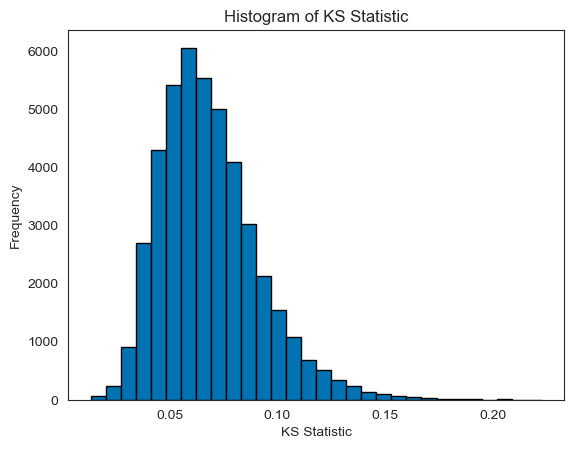

In [630]:
plt.hist(ks_result['ks_statistic'], bins=30, edgecolor='black')
plt.title('Histogram of KS Statistic')
plt.xlabel('KS Statistic')
plt.ylabel('Frequency')
plt.show()

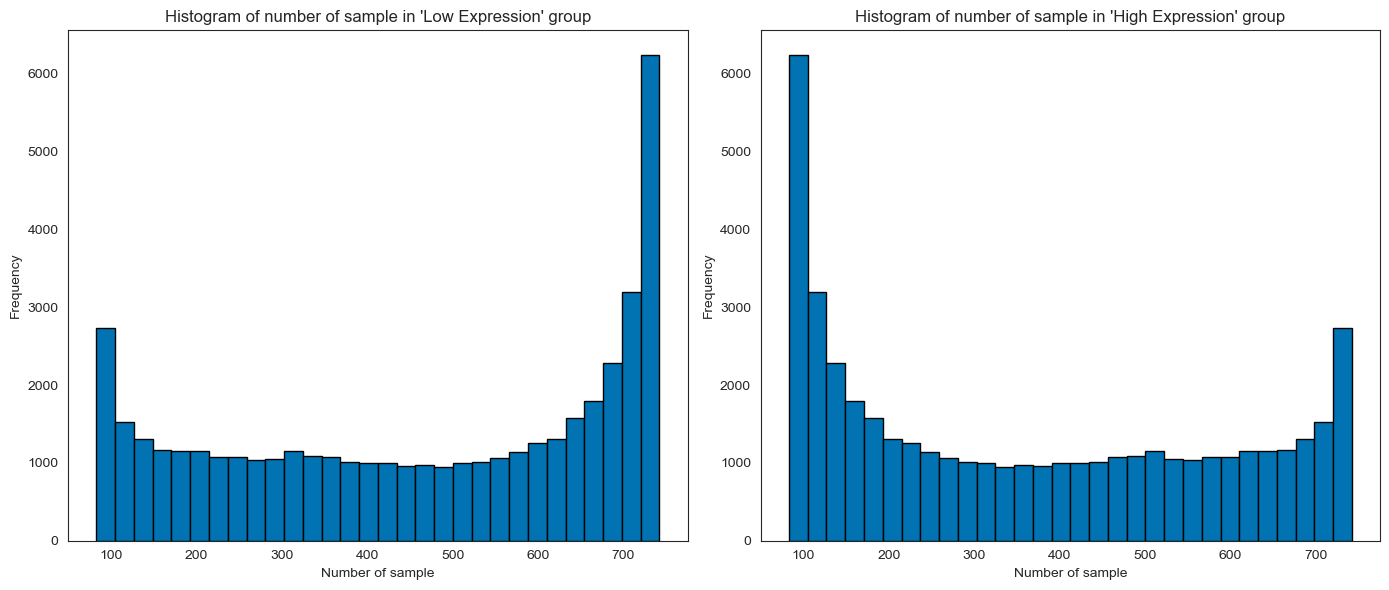

In [631]:
# Plot sample group size
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
ax[0].hist(ks_result['size_le'], bins=30, edgecolor='black')
ax[0].set_xlabel('Number of sample')
ax[0].set_ylabel('Frequency')
ax[0].set_title("Histogram of number of sample in 'Low Expression' group")
ax[1].hist(ks_result['size_he'], bins=30, edgecolor='black')
ax[1].set_xlabel('Number of sample')
ax[1].set_ylabel('Frequency')
ax[1].set_title("Histogram of number of sample in 'High Expression' group")
plt.tight_layout()
plt.show()

In [1200]:
# Calculate bootstrap p-value for top genes
km_df = filtered_df.copy()
num_simulation = 5000
for gene in intersection_list:
    ks_obs = filtered_df.loc[filtered_df['gene'] == gene, 'ks_statistic'].iloc[0]
    ks_stats_sim, p_value = bootstrap_test(survival_time, ks_obs, num_simulation)
    km_df.loc[km_df['gene'] == gene, 'bootstrap_p'] = p_value

In [1201]:
# Filter result with p-value
km_df = km_df[km_df['bootstrap_p'] <= 0.001]
km_df

,gene,threshold,pvalue,ks_statistic,size_le,size_he,bootstrap_p


In [1202]:
# Get top gene lists
gene_list_intersection = km_df.iloc[:, 0].to_list()
for gene in gene_list_intersection:
    print(gene_id_to_name.get(gene, gene))

In [1204]:
# Plot KM Curves
for i, gene in enumerate(gene_list_intersection[:5]):

    # Get gene count of that gene
    row = pd.to_numeric(df_with_subtype.loc[gene].values, errors='coerce')
    # Find the median value
    # optimal_threshold = np.median(row)
    # print(median_value)

    # Get optimal threshold for that gene
    tbl = ks_result[ks_result['gene'] == gene]
    optimal_threshold = pd.to_numeric(tbl['threshold'].values[0], errors='coerce')

    # Extract days to death
    time_g1 = survival_time[row <= optimal_threshold]
    time_g2 = survival_time[row > optimal_threshold]
    
    # Extract status
    status_g1 = status[row <= optimal_threshold]
    status_g2 = status[row > optimal_threshold]

    data_g1 = pd.DataFrame({
        'survival_time': time_g1,
        'event_occurred': status_g1})

    data_g2 = pd.DataFrame({
    'survival_time': time_g2,
    'event_occurred': status_g2})

    # Extract KS_statistics
    ks_stat = round(tbl['ks_statistic'].values[0], 4)
    ks_pval = round(tbl['pvalue'].values[0], 4)
    # ks_stat, ks_pval = ks_2samp(time_g1, time_g2)
    text = f"KS Statistic = {round(ks_stat, 4)}, p-value = {round(ks_pval, 4)}"

    # print("Calculated KS", ks_2samp(time_g1, time_g2))

    # Fit KaplanMeierFitter
    kmf_1 = KaplanMeierFitter()
    kmf_2 = KaplanMeierFitter()
    kmf_1.fit(data_g1['survival_time'], data_g1['event_occurred'], label=f"Gene counts <= {round(optimal_threshold, 4)}")
    kmf_2.fit(data_g2['survival_time'], data_g2['event_occurred'], label=f"Gene counts > {round(optimal_threshold, 4)}")

    # Plot Kaplan-Meier survival functions
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Top subplot
    ax = axs[0]
    kmf_1.plot_survival_function(ax=ax, ci_show=False, linestyle='dashed', linewidth=2, color=sns.color_palette('colorblind')[2])
    kmf_2.plot_survival_function(ax=ax, ci_show=False, linestyle='solid', linewidth=2, color=sns.color_palette('colorblind')[3])
    add_at_risk_counts(kmf_1, kmf_2, ax=ax, rows_to_show=['At risk', 'Events'])

    ax.set_title(f"KM Plot: {gene_id_to_name.get(gene, gene)} ({gene}) \n {text}")
    ax.set_xlabel("Survival Time (days)")
    ax.set_ylabel("Survival Probability")
    ax.grid(True)
    ax.legend()
    
    ###########
    # Extract subtypes
    type_g1 = subtypes[row <= optimal_threshold]
    type_g2 = subtypes[row > optimal_threshold]

    # Count occurrences of each unique type
    unique_values = np.unique(np.concatenate([type_g1, type_g2]))

    # Count occurrences for each unique value in result1 and result2
    counts_result1 = np.array([np.count_nonzero(type_g1 == val) for val in unique_values])
    counts_result2 = np.array([np.count_nonzero(type_g2 == val) for val in unique_values])

    # Create a DataFrame directly
    df = pd.DataFrame({
        'Count': unique_values,
        'Low Expression': counts_result1,
        'High Expression': counts_result2
    }).set_index('Count')

    # Normalize the DataFrame to get proportions
    df_normalized = df.div(df.sum(axis=1), axis=0)

    # Bottom subplot
    ax = axs[1]
    # df.plot(kind='barh', stacked=True, color=[palette[2], palette[3]], ax=ax)
    # df_normalized.plot(kind='bar', stacked=True, color=[palette[2], palette[3]], ax=ax)
    df.plot(kind='bar', stacked=True, color=[palette[2], palette[3]], ax=ax)
    ax.set_xlabel('BRCA Subtype')
    ax.set_xticklabels(df.index, rotation=0)
    ax.set_ylabel('Count')
    ax.set_title('Number of Patients in each Breast Cancer Subtype')
    ax.legend()
    ax.grid()
    plt.tight_layout()
    plt.show()

### LumA

In [1205]:
def plot_km(gene_list, result_df, subtype):
    for gene in gene_list:
        # Get gene count
        row = pd.to_numeric(norm_count.loc[gene].values, errors='coerce')

        # Get optimal threshold for that gene
        tbl = result_df[result_df['gene'] == gene]
        optimal_threshold = pd.to_numeric(tbl[f'threshold_{subtype}'].values[0], errors='coerce')
        
        # Subtype masking
        mask = (subtypes == subtype)
        time = survival_time[mask]
        event = status[mask]
        count = row[mask]
        
        # Split time, status based on current threshold
        time_g1 = time[count <= optimal_threshold]
        time_g2 = time[count > optimal_threshold]
        status_g1 = event[count <= optimal_threshold]
        status_g2 = event[count > optimal_threshold]

        # Perform KS test
        if len(time_g1) >= 1 and len(time_g2) >= 1:
            ks_test = ks_2samp(time_g1, time_g2) 
            ks_stat = round(ks_test.statistic, 4)
            ks_pval = round(ks_test.pvalue, 4)

        # Fit KaplanMeierFitter
        _, ax = plt.subplots(figsize=(6, 4))
        kmf_1 = KaplanMeierFitter()
        kmf_2 = KaplanMeierFitter()
        kmf_1.fit(time_g1, status_g1, label=f"Gene counts <= {round(optimal_threshold, 4)}")
        kmf_2.fit(time_g2, status_g2, label=f"Gene counts > {round(optimal_threshold, 4)}")

        kmf_1.plot_survival_function(ax=ax, ci_show=False, linestyle='dashed', linewidth=2, color=sns.color_palette('colorblind')[2])
        kmf_2.plot_survival_function(ax=ax, ci_show=False, linestyle='solid', linewidth=2, color=sns.color_palette('colorblind')[3])
        add_at_risk_counts(kmf_1, kmf_2, ax=ax, rows_to_show=['At risk', 'Events'])

        text = f"KS Statistic = {ks_stat}, p-value = {ks_pval}"
        ax.set_title(f"KM Plot: {gene_id_to_name.get(gene, gene)} ({gene}) \n {text}")
        ax.set_xlabel("Survival Time (days)")
        ax.set_ylabel("Survival Probability")
        ax.grid()
        ax.legend();

In [1206]:
def plot_distribution(list, real_val, gene, p_val, subtype):
    plt.figure(figsize=(6, 4))
    obs_color = palette[2]
    # min_color = palette[1]
    # max_color = palette[3]
    # Calculate min and max values
    # min = np.min(list)
    # max = np.max(list)
    # Plot histogram with KDE
    sns.histplot(list, bins=60, kde=True, edgecolor='black')
    plt.axvline(real_val, color=obs_color, linestyle='--', label=f'Observed KS statistic: {real_val:.4f}', linewidth=2) 
    # plt.axvline(min, color=min_color, linestyle='--', label=f'Min simulated KS statistic: {min:.4f}', linewidth=2)
    # plt.axvline(max, color=max_color, linestyle='--', label=f'Max simulated KS statistic: {max:.4f}', linewidth=2) 
    text = f'KS Statistic Estimated Null Distribution ({subtype}) \n Gene: {gene_id_to_name.get(gene, gene)} (p = {p_val})' 
    plt.title(f'{text}', fontsize=10)
    plt.xlabel('KS statistic')
    plt.ylabel('Frequency')
    plt.legend(fontsize=8)
    plt.grid()
    plt.show()

def bootstrap_test(survival_time, real_ks, num_simulation, subtype):
    ks_stats_sim = []  
    # ks_pvals_sim = []
    
    for _ in range(num_simulation):
        # Subtype masking
        mask = (subtypes == subtype)
        time = survival_time[mask]

        # Select a random split index
        split_index = np.random.randint(1, len(time)//2)

        # Shuffle the data
        shuffled_data = time.copy()
        np.random.shuffle(shuffled_data)

        # Divide the data based on the split index
        group1 = shuffled_data[:split_index]
        group2 = shuffled_data[split_index:]

        # Calculate Dictance
        ks_stat_sim, _ = ks_2samp(group1, group2)
        ks_stats_sim.append(ks_stat_sim)
        # ks_pvals_sim.append(ks_pval_sim)
    
    # Performing a one-sided test
    extreme_count = np.sum(np.array(ks_stats_sim) > real_ks)
    p_value = extreme_count / len(ks_stats_sim)

    # Plot simulation distribution
    # plot_distribution(ks_stats_sim, real_ks, gene, p_value.round(6), subtype)
    return ks_stats_sim, p_value

In [1207]:
# Read and sort the result by high ks_statistic
subtype = 'LumA'
ks_result = pd.read_csv(f'./result2/ks_{subtype}.csv', sep=',')
ks_result = ks_result[ks_result[f'ks_statistic_{subtype}'] != -np.inf].sort_values(by=f'pvalue_{subtype}')
ks_result

,gene,threshold_LumA,pvalue_LumA,ks_statistic_LumA,size_le,size_he
14763,ENSG00000179933.6,0.015378,0.0,1.0000,2,417
13383,ENSG00000172809.13,0.071069,0.0,0.9130,5,414
12776,ENSG00000170270.5,0.002826,0.0,0.9832,3,416
1049,ENSG00000068697.7,0.113595,0.0,0.9760,3,416
6842,ENSG00000134153.10,0.015281,0.0,0.9130,5,414
...,...,...,...,...,...,...
49935,ENSG00000268842.1,NaN,inf,0.1268,418,1
53682,ENSG00000276149.1,NaN,inf,0.0832,219,200
48520,ENSG00000266039.1,NaN,inf,0.1034,406,13
19299,ENSG00000202021.1,NaN,inf,0.1069,373,46


In [1208]:
# Filter result with p-value
filtered_df = ks_result[ks_result[f'pvalue_{subtype}'] <= 0.01]
filtered_df

,gene,threshold_LumA,pvalue_LumA,ks_statistic_LumA,size_le,size_he
14763,ENSG00000179933.6,0.015378,0.0000,1.0000,2,417
13383,ENSG00000172809.13,0.071069,0.0000,0.9130,5,414
12776,ENSG00000170270.5,0.002826,0.0000,0.9832,3,416
1049,ENSG00000068697.7,0.113595,0.0000,0.9760,3,416
6842,ENSG00000134153.10,0.015281,0.0000,0.9130,5,414
...,...,...,...,...,...,...
6192,ENSG00000129968.17,0.004981,0.0095,0.9976,1,418
11205,ENSG00000164035.10,0.044321,0.0099,0.6207,413,6
51414,ENSG00000271780.1,0.000340,0.0099,0.3885,17,402
12545,ENSG00000169223.15,0.050002,0.0099,0.3885,17,402


In [1209]:
# Get top gene lists
gene_list_LumA = filtered_df.iloc[:, 0].to_list()
len(gene_list_LumA)

592

In [1210]:
# Calculate bootstrap p-value for top genes
km_df = filtered_df.copy()
num_simulation = 5000
for gene in gene_list_LumA:
    ks_obs = filtered_df.loc[filtered_df['gene'] == gene, f'ks_statistic_{subtype}'].iloc[0]
    ks_stats_sim, p_value = bootstrap_test(survival_time, ks_obs, num_simulation, subtype)
    km_df.loc[km_df['gene'] == gene, 'bootstrap_p'] = p_value

In [1211]:
# Filter result with p-value
km_df = km_df[km_df['bootstrap_p'] <= 0.001]
km_df

,gene,threshold_LumA,pvalue_LumA,ks_statistic_LumA,size_le,size_he,bootstrap_p
14763,ENSG00000179933.6,0.015378,0.0000,1.0000,2,417,0.0000
13383,ENSG00000172809.13,0.071069,0.0000,0.9130,5,414,0.0006
12776,ENSG00000170270.5,0.002826,0.0000,0.9832,3,416,0.0000
1049,ENSG00000068697.7,0.113595,0.0000,0.9760,3,416,0.0000
6842,ENSG00000134153.10,0.015281,0.0000,0.9130,5,414,0.0002
...,...,...,...,...,...,...,...
9086,ENSG00000148384.14,0.002362,0.0095,0.9976,1,418,0.0000
8217,ENSG00000142252.11,0.000031,0.0095,0.9976,1,418,0.0000
2184,ENSG00000100092.24,0.000487,0.0095,0.9976,1,418,0.0000
6192,ENSG00000129968.17,0.004981,0.0095,0.9976,1,418,0.0000


In [1212]:
# Get top gene lists
gene_list_LumA = km_df.iloc[:, 0].to_list()
for gene in gene_list_LumA:
    print(gene_id_to_name.get(gene, gene))

C14orf119
RPL38
GON7
LAPTM4A
EMC7
SETD3
RPL36AL
RPL14P1
ALG14
RPS6KA1
PPIH
FAM136A
AP002381.2
BTBD6
RCAN3
PPIAP21
AGMAT
TBKBP1
WDR75
ADGRL4
CDC37
AC073861.1
LSM7
AC010300.1
AC026979.2
IL33
FAM162B
SNX22
SNRPD2
TECR
NPM3
ZCCHC17
MGAM2
PTBP1
TMEM59
PISD
GLG1
SMR3A
TRAPPC3
SPINT1
NIFK
FBL
PIEZO2
MED26
RPS11P5
NGDN
SPART
AC009312.1
MRPS7
RPS7P10
NR2C2AP
IYD
DNAJA2
BCAS4
RPS7
TH
ITFG1
UQCRH
CPEB3
RNF7
PSMB5
PPP2R5C
HSP90B1
MBD2
PRRG3
POLR3C
SNRNP27
CGRRF1
EAPP
PPHLN1
TXNL1
CAMK2N1
RPF1
PTEN
YJU2
EBAG9
SNHG30
MAP2K4
BRF1
SLC6A9
EEF1AKMT4
CKB
AC012413.1
AC005562.2
MCEE
RAMP3
ZNF582-AS1
PABPC1P4
CASP14
BCL10
ANAPC10
TMA16
TSNAX
MOAP1
MLPH
ZNF554
ARHGEF9
TCEA3
GS1-594A7.3
HMX1
ARL8A
CERS4
PREB
MPC2
GRAMD1A
HAUS8
AC012615.1
IGKC
TMEM120B
AGTRAP
TLE5
SCAMP4
LINC00852
DEDD
NFIC
PSMB4
TOR3A
DCAF11
TMEM161A
TRMT1
TRIM25
ZDHHC24
EFCAB11
ELAVL1
C11orf49
MS4A1
SHE
OR7E29P
MRI1
FDFT1
SMOX
RNA5SP124
AC019080.5
MCRS1
ST6GALNAC5
ZNF536
DPP7
TBC1D10A
C19orf48
AC079906.1
KLHL30
IER5
CXCL16
ENOSF1
TIA1
RPL36


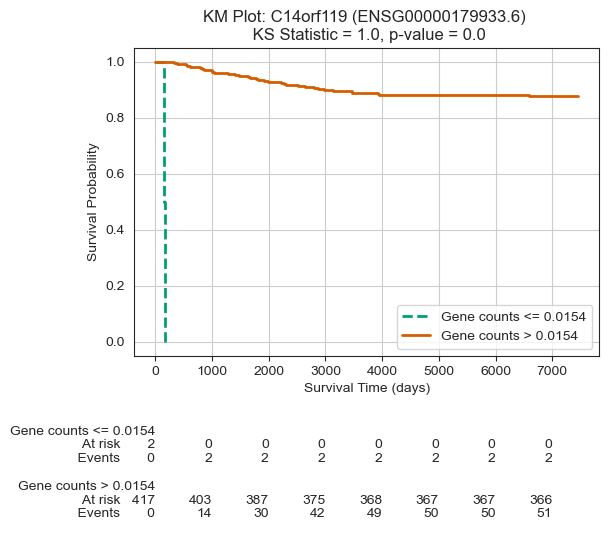

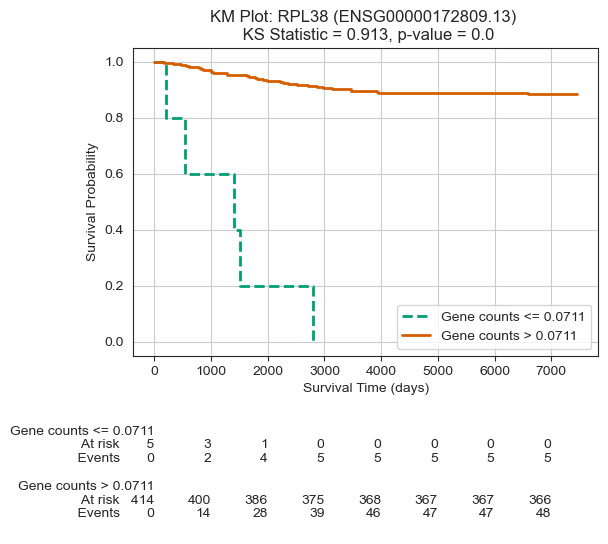

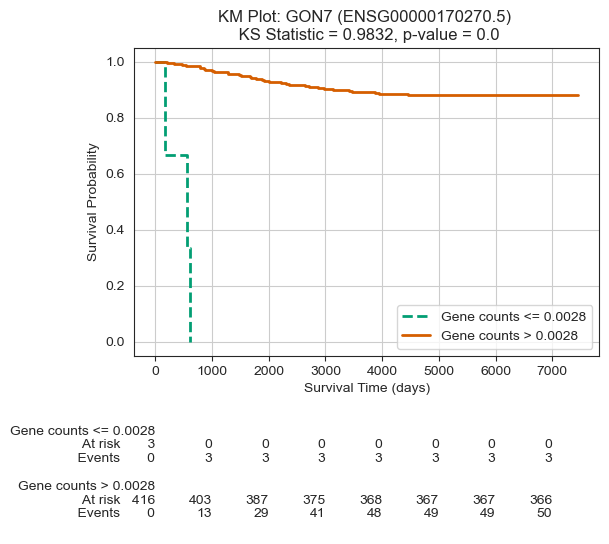

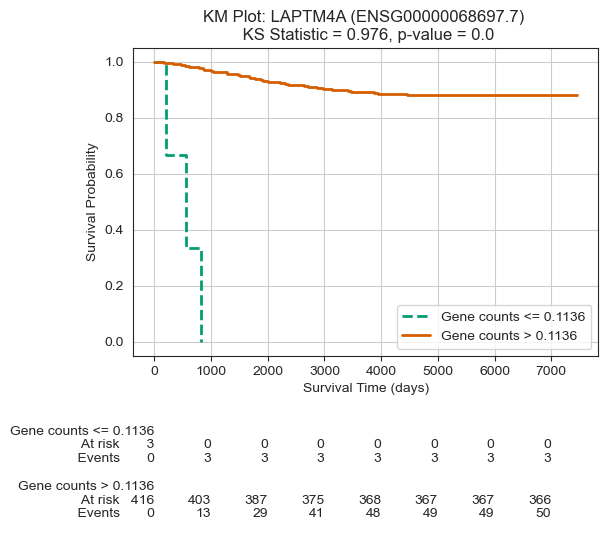

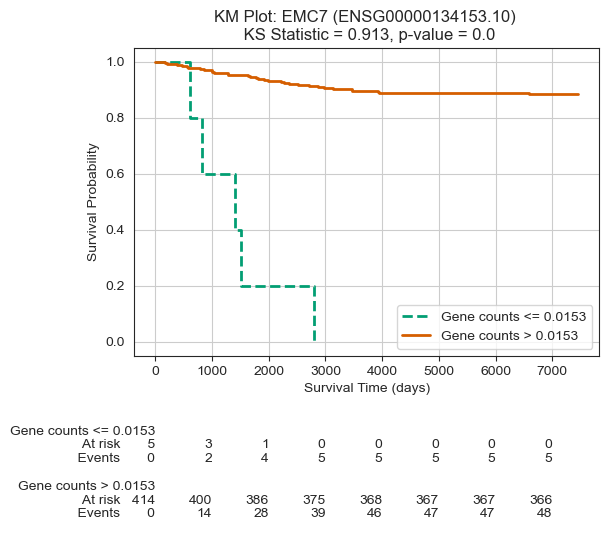

In [1213]:
plot_km(gene_list_LumA[:5], filtered_df, subtype)

### LumB

In [1214]:
# Read and sort the result by high ks_statistic
subtype = 'LumB'
ks_result = pd.read_csv(f'./result2/ks_{subtype}.csv', sep=',')
ks_result = ks_result[ks_result[f'ks_statistic_{subtype}'] != -np.inf].sort_values(by=f'pvalue_{subtype}')
ks_result

,gene,threshold_LumB,pvalue_LumB,ks_statistic_LumB,size_le,size_he
293,ENSG00000011332.19,0.000043,0.0,0.9593,4,172
223,ENSG00000008516.17,0.000196,0.0,0.9123,5,171
47507,ENSG00000263823.1,0.000047,0.0,0.9064,5,171
12260,ENSG00000168028.14,0.088089,0.0,0.9884,3,173
5914,ENSG00000127415.13,0.002185,0.0,0.9064,5,171
...,...,...,...,...,...,...
44828,ENSG00000259049.1,NaN,inf,0.1356,118,58
57580,ENSG00000284547.1,NaN,inf,0.1543,175,1
26179,ENSG00000225653.1,NaN,inf,0.1537,85,91
18605,ENSG00000200486.1,NaN,inf,0.1570,172,4


In [1215]:
# Filter result with p-value
filtered_df = ks_result[ks_result[f'pvalue_{subtype}'] <= 0.01]
filtered_df

,gene,threshold_LumB,pvalue_LumB,ks_statistic_LumB,size_le,size_he
293,ENSG00000011332.19,0.000043,0.0000,0.9593,4,172
223,ENSG00000008516.17,0.000196,0.0000,0.9123,5,171
47507,ENSG00000263823.1,0.000047,0.0000,0.9064,5,171
12260,ENSG00000168028.14,0.088089,0.0000,0.9884,3,173
5914,ENSG00000127415.13,0.002185,0.0000,0.9064,5,171
...,...,...,...,...,...,...
3644,ENSG00000109180.15,0.047753,0.0099,0.4215,15,161
2292,ENSG00000100385.14,0.001764,0.0099,0.4215,15,161
1331,ENSG00000075975.17,0.012137,0.0099,0.4215,15,161
1301,ENSG00000075336.12,0.006190,0.0100,0.4848,11,165


In [1216]:
# Get top gene lists
gene_list_LumB = filtered_df.iloc[:, 0].to_list()
len(gene_list_LumB)

1311

In [1217]:
# Calculate bootstrap p-value for top genes
km_df = filtered_df.copy()
num_simulation = 5000
for gene in gene_list_LumB:
    ks_obs = filtered_df.loc[filtered_df['gene'] == gene, f'ks_statistic_{subtype}'].iloc[0]
    ks_stats_sim, p_value = bootstrap_test(survival_time, ks_obs, num_simulation, subtype)
    km_df.loc[km_df['gene'] == gene, 'bootstrap_p'] = p_value

In [1218]:
# Filter result with p-value
km_df = km_df[km_df['bootstrap_p'] <= 0.001]
km_df

,gene,threshold_LumB,pvalue_LumB,ks_statistic_LumB,size_le,size_he,bootstrap_p
223,ENSG00000008516.17,0.000196,0.0000,0.9123,5,171,0.0008
12260,ENSG00000168028.14,0.088089,0.0000,0.9884,3,173,0.0000
5914,ENSG00000127415.13,0.002185,0.0000,0.9064,5,171,0.0010
8503,ENSG00000144021.3,0.028295,0.0000,0.9064,5,171,0.0010
7256,ENSG00000136279.21,0.031214,0.0000,0.9064,5,171,0.0008
...,...,...,...,...,...,...,...
34760,ENSG00000238249.2,0.000184,0.0086,0.9425,2,174,0.0004
34309,ENSG00000237594.2,0.000012,0.0086,0.9425,2,174,0.0002
54992,ENSG00000278784.1,0.000337,0.0086,0.9425,2,174,0.0004
17784,ENSG00000198589.14,0.028381,0.0086,0.9425,2,174,0.0006


In [1219]:
# Get top gene lists
gene_list_LumB = km_df.iloc[:, 0].to_list()
for gene in gene_list_LumB:
    print(gene_id_to_name.get(gene, gene))

MMP25
RPSA
IDUA
CIAO1
DBNL
TNFRSF14
ADAMTS13
NUDT9
RASSF1
APOA4
HSD17B1P1
UBXN11
RPS11
COA8
RPL5P34
HMGA2
AC064799.1
CASKIN1
SELENOK
GJD3
VAMP8
RPS15
VIPR1
TSHZ1
STYXL1
NOXA1
AC092279.1
RPL27
AL158206.1
PHF7
TNFRSF14-AS1
IK
MLPH
RPL18
AC097382.3
FAM177A1
PRKCH
NLRC3
SLC8A1-AS1
NTN5
RNASET2
NXF3
HSD52
AC012236.1
RPL24P8
ACP2
GZMM
AC139100.2
Y_RNA
LINC01311
HNRNPLP2
AC104633.1
MTCO2P16
ARPC3P3
SQSTM1P1
COPS2
MTATP6P16
AL049759.1
PPP1R7
LINC01909
RITA1
LMNTD2-AS1
CCDC88B
FBL
RPL18A
RPL12
LINC01106
FBXL12
TNFRSF18
RPL11
IQCE
AC131235.1
AC006449.6
RPL36
PET100
APEX1
RPS28
RALGDS
SRP14P2
PSMG3
HSF4
RPL14P1
ZNF821
MRPL54
TENT5C
TOMM7
FAM156A
AL133264.1
BCAS4
SH2B2
CREB3
RN7SL138P
MTHFR
DPP7
ARHGAP4
DIS3L2
AC245060.5
MRPL9
DDR1
AP001160.4
NHLRC4
NRADDP
EIF3M
PARD6G-AS1
AL445933.1
CASP14
C7orf26
AC115618.1
LFNG
AC092110.1
GSG1L2
ANKLE2
GPLD1
NEK2P1
RIMS3
AC018638.7
PCCA-DT
MMP9
CIRBP-AS1
CCAR1
AC026320.1
AC073861.1
ZFAND3
ELOB
MVB12A
FAHD2B
POF1B
RDH11
MRPL19
RAB21
PCNP
GSK3B
PEX7
SCFD1
HECTD1


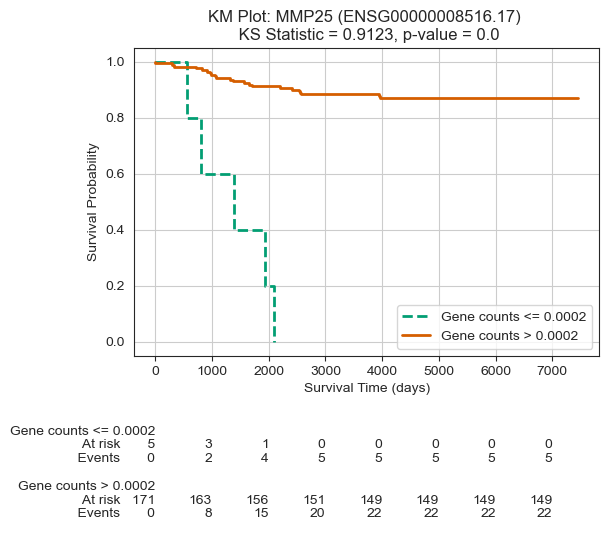

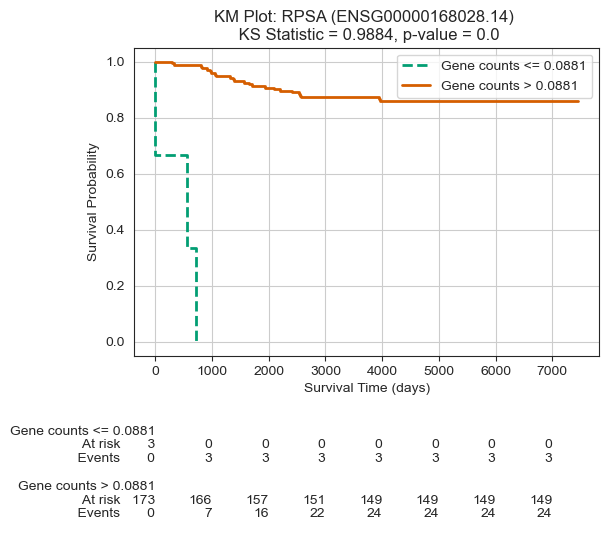

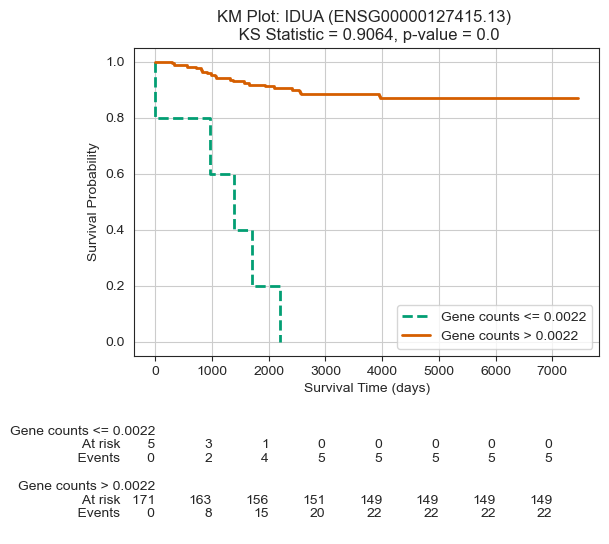

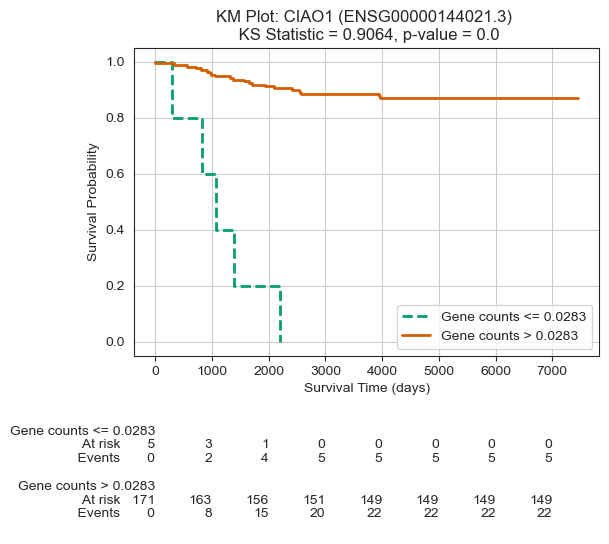

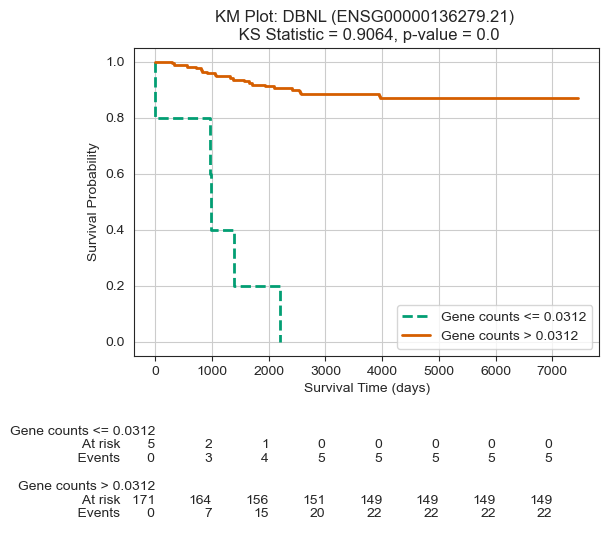

In [1220]:
plot_km(gene_list_LumB[:5], filtered_df, subtype)

### Her2

In [1221]:
# Read and sort the result by high ks_statistic
subtype = 'Her2'
ks_result = pd.read_csv(f'./result2/ks_{subtype}.csv', sep=',')
ks_result = ks_result[ks_result[f'ks_statistic_{subtype}'] != -np.inf].sort_values(by=f'pvalue_{subtype}')
ks_result

,gene,threshold_Her2,pvalue_Her2,ks_statistic_Her2,size_le,size_he
5550,ENSG00000124575.7,0.000009,0.0,0.9492,5,59
55450,ENSG00000279381.1,0.000022,0.0,1.0000,61,3
32486,ENSG00000234915.1,0.000022,0.0,1.0000,61,3
30694,ENSG00000232301.2,0.000000,0.0,0.7104,51,13
27483,ENSG00000227521.2,0.000000,0.0,0.9667,60,4
...,...,...,...,...,...,...
29465,ENSG00000230476.1,NaN,inf,0.3710,62,2
16284,ENSG00000186599.8,NaN,inf,0.2500,52,12
55126,ENSG00000278977.1,NaN,inf,0.2131,61,3
20941,ENSG00000207269.1,NaN,inf,0.2097,62,2


In [1222]:
# Filter result with p-value
filtered_df = ks_result[ks_result[f'pvalue_{subtype}'] <= 0.01]
filtered_df

,gene,threshold_Her2,pvalue_Her2,ks_statistic_Her2,size_le,size_he
5550,ENSG00000124575.7,0.000009,0.0000,0.9492,5,59
55450,ENSG00000279381.1,0.000022,0.0000,1.0000,61,3
32486,ENSG00000234915.1,0.000022,0.0000,1.0000,61,3
30694,ENSG00000232301.2,0.000000,0.0000,0.7104,51,13
27483,ENSG00000227521.2,0.000000,0.0000,0.9667,60,4
...,...,...,...,...,...,...
48075,ENSG00000265078.2,0.000021,0.0099,0.9516,62,2
33565,ENSG00000236509.2,0.000022,0.0099,0.9516,62,2
6823,ENSG00000134042.14,0.002262,0.0099,0.9516,62,2
22516,ENSG00000213770.3,0.000139,0.0099,0.9516,62,2


In [1223]:
# Get top gene lists
gene_list_Her2 = filtered_df.iloc[:, 0].to_list()
len(gene_list_Her2)

1038

In [1224]:
# Calculate bootstrap p-value for top genes
km_df = filtered_df.copy()
num_simulation = 5000
for gene in gene_list_Her2:
    ks_obs = filtered_df.loc[filtered_df['gene'] == gene, f'ks_statistic_{subtype}'].iloc[0]
    ks_stats_sim, p_value = bootstrap_test(survival_time, ks_obs, num_simulation, subtype)
    km_df.loc[km_df['gene'] == gene, 'bootstrap_p'] = p_value

In [1225]:
# Filter result with p-value
km_df = km_df[km_df['bootstrap_p'] <= 0.001]
km_df

,gene,threshold_Her2,pvalue_Her2,ks_statistic_Her2,size_le,size_he,bootstrap_p
55450,ENSG00000279381.1,0.000022,0.0000,1.0000,61,3,0.0000
32486,ENSG00000234915.1,0.000022,0.0000,1.0000,61,3,0.0000
32623,ENSG00000235106.10,0.019485,0.0000,1.0000,61,3,0.0000
32663,ENSG00000235159.1,0.000199,0.0000,1.0000,61,3,0.0000
59659,ENSG00000287254.1,0.000036,0.0000,1.0000,61,3,0.0000
...,...,...,...,...,...,...,...
44210,ENSG00000258316.1,0.000036,0.0099,0.9516,62,2,0.0008
8221,ENSG00000142319.18,0.001155,0.0099,0.9516,62,2,0.0010
22608,ENSG00000213964.3,0.000016,0.0099,0.9516,62,2,0.0010
56243,ENSG00000280376.1,0.000042,0.0099,0.9516,62,2,0.0008


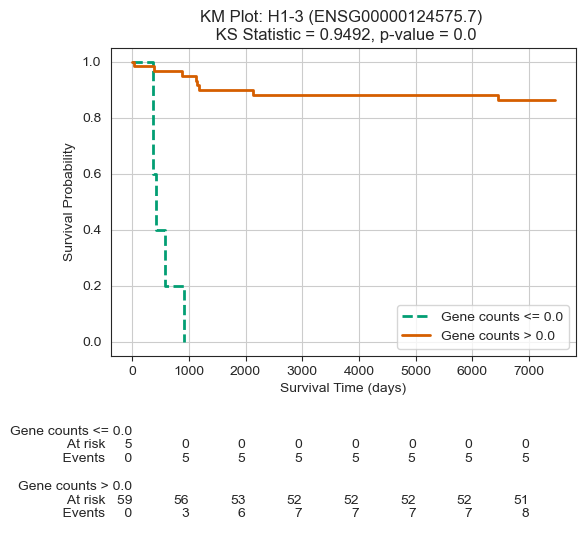

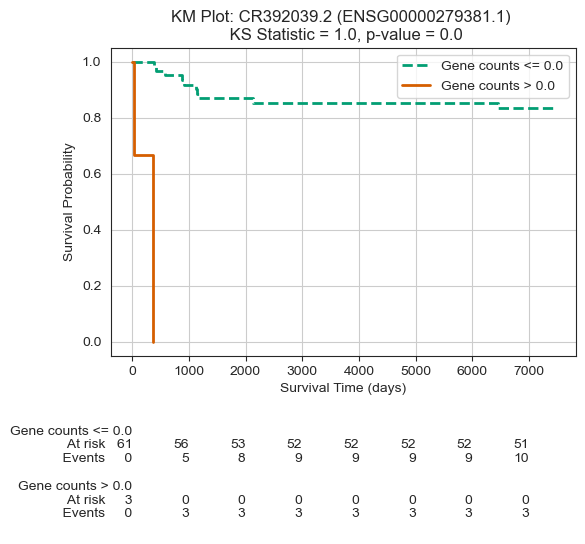

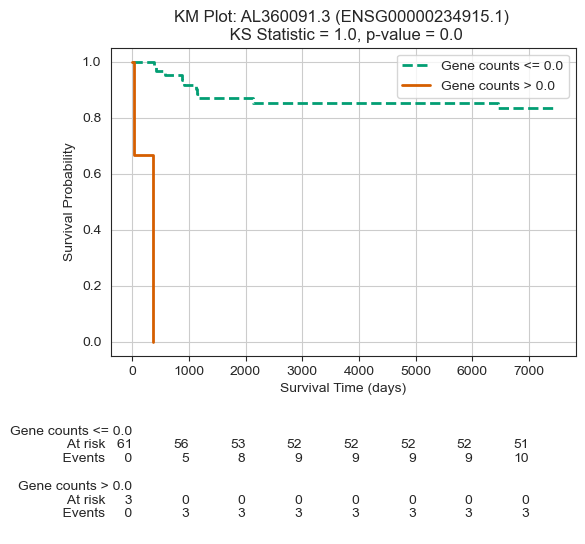

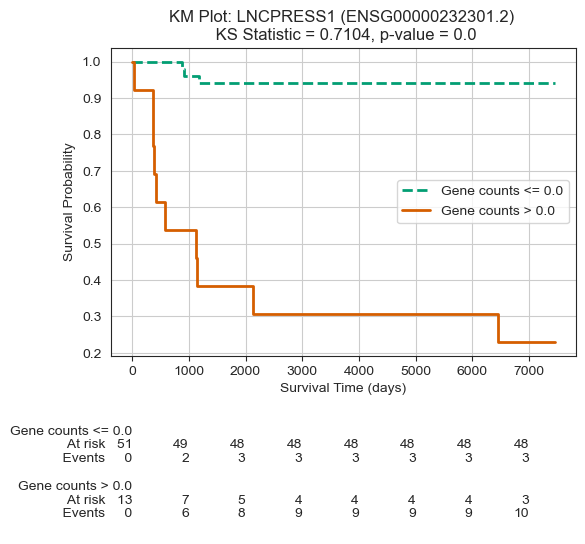

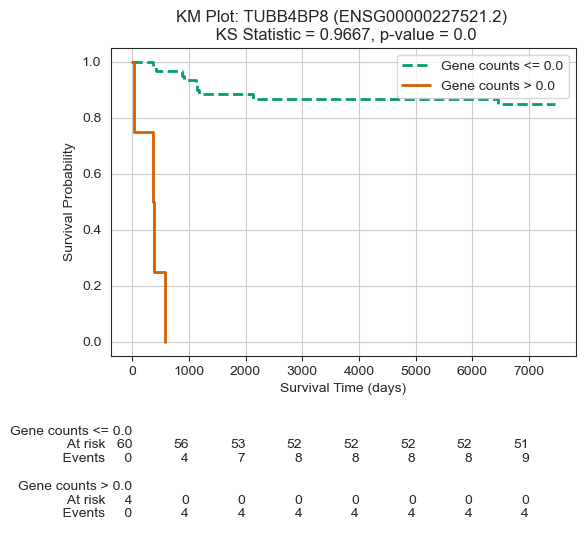

In [1226]:
plot_km(gene_list_Her2[:5], filtered_df, subtype)

### Basal

In [1227]:
# Read and sort the result by high ks_statistic
subtype = 'Basal'
ks_result = pd.read_csv(f'./result2/ks_{subtype}.csv', sep=',')
ks_result = ks_result[ks_result[f'ks_statistic_{subtype}'] != -np.inf].sort_values(by=f'pvalue_{subtype}')
ks_result

,gene,threshold_Basal,pvalue_Basal,ks_statistic_Basal,size_le,size_he
7129,ENSG00000135679.25,0.009903,0.0,0.9781,4,137
9500,ENSG00000152193.8,0.001966,0.0,0.9855,3,138
7680,ENSG00000138587.6,0.000109,0.0,0.9928,3,138
4646,ENSG00000116977.19,0.005867,0.0,0.9855,3,138
9521,ENSG00000152332.16,0.034286,0.0,0.9118,5,136
...,...,...,...,...,...,...
31006,ENSG00000232764.1,NaN,inf,0.2185,118,23
47384,ENSG00000263585.1,NaN,inf,0.3485,136,5
47381,ENSG00000263581.1,NaN,inf,0.4424,139,2
23872,ENSG00000220986.1,NaN,inf,0.9429,140,1


In [1228]:
# Filter result with p-value
filtered_df = ks_result[ks_result[f'pvalue_{subtype}'] <= 0.01]
filtered_df

,gene,threshold_Basal,pvalue_Basal,ks_statistic_Basal,size_le,size_he
7129,ENSG00000135679.25,0.009903,0.0000,0.9781,4,137
9500,ENSG00000152193.8,0.001966,0.0000,0.9855,3,138
7680,ENSG00000138587.6,0.000109,0.0000,0.9928,3,138
4646,ENSG00000116977.19,0.005867,0.0000,0.9855,3,138
9521,ENSG00000152332.16,0.034286,0.0000,0.9118,5,136
...,...,...,...,...,...,...
46052,ENSG00000260625.3,0.000318,0.0099,0.5084,131,10
14987,ENSG00000181085.15,0.005361,0.0099,0.3005,103,38
25855,ENSG00000225172.6,0.000020,0.0100,0.4690,129,12
232,ENSG00000009307.16,0.119617,0.0100,0.6824,5,136


In [1229]:
# Get top gene lists
gene_list_Basal = filtered_df.iloc[:, 0].to_list()
len(gene_list_Basal)

2074

In [1230]:
# Calculate bootstrap p-value for top genes
km_df = filtered_df.copy()
num_simulation = 5000
for gene in gene_list_Basal:
    ks_obs = filtered_df.loc[filtered_df['gene'] == gene, f'ks_statistic_{subtype}'].iloc[0]
    ks_stats_sim, p_value = bootstrap_test(survival_time, ks_obs, num_simulation, subtype)
    km_df.loc[km_df['gene'] == gene, 'bootstrap_p'] = p_value

In [1231]:
# Filter result with p-value
km_df = km_df[km_df['bootstrap_p'] <= 0.001]
km_df

,gene,threshold_Basal,pvalue_Basal,ks_statistic_Basal,size_le,size_he,bootstrap_p
7129,ENSG00000135679.25,0.009903,0.0000,0.9781,4,137,0.0008
9500,ENSG00000152193.8,0.001966,0.0000,0.9855,3,138,0.0002
7680,ENSG00000138587.6,0.000109,0.0000,0.9928,3,138,0.0004
4646,ENSG00000116977.19,0.005867,0.0000,0.9855,3,138,0.0000
8562,ENSG00000144445.17,0.001740,0.0000,0.9855,3,138,0.0002
...,...,...,...,...,...,...,...
6939,ENSG00000134684.11,0.022827,0.0091,0.9424,2,139,0.0006
3114,ENSG00000105472.13,0.016574,0.0091,0.9424,139,2,0.0006
8337,ENSG00000143196.5,0.015983,0.0091,0.9424,139,2,0.0010
47387,ENSG00000263590.2,0.000043,0.0091,0.9424,139,2,0.0004


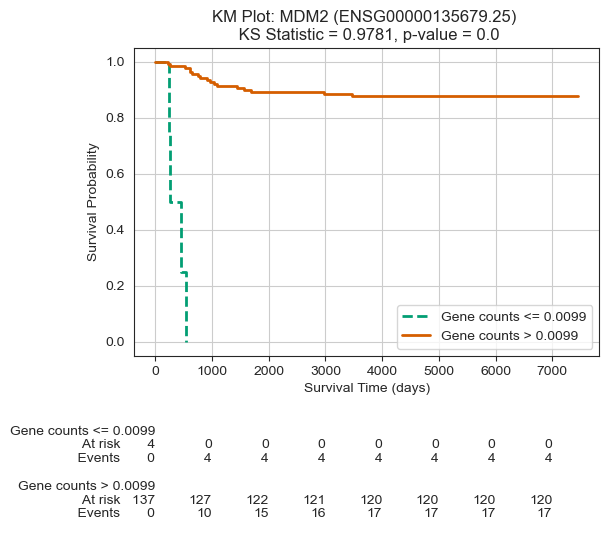

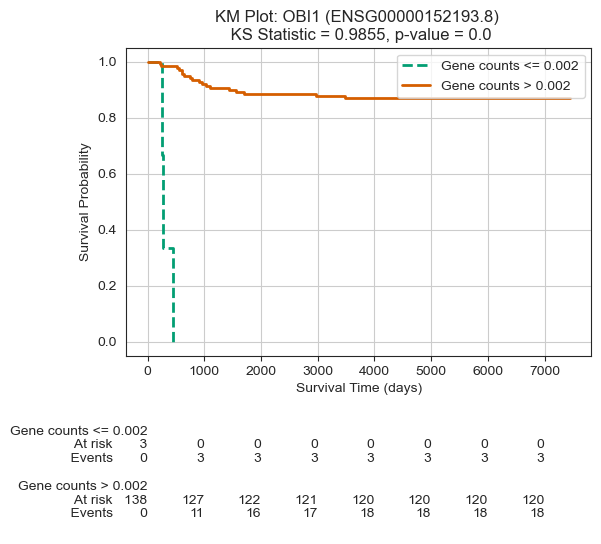

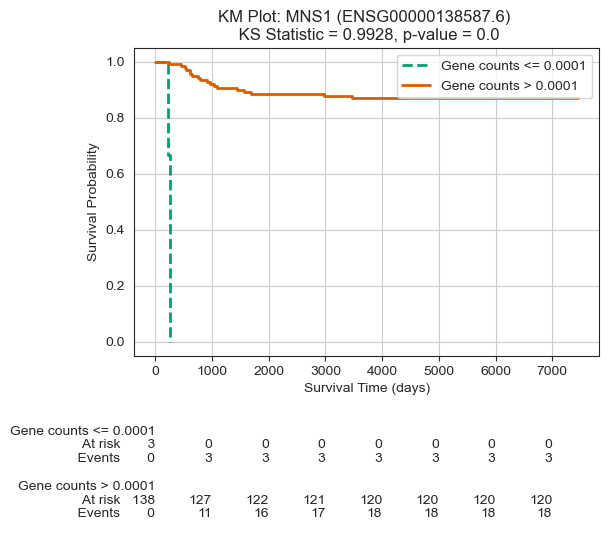

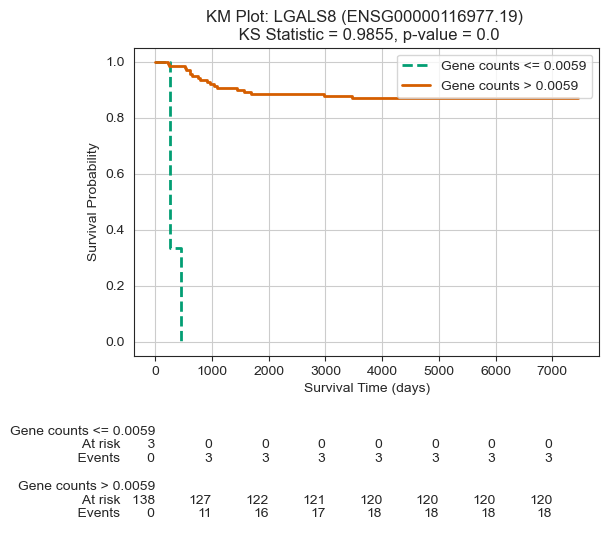

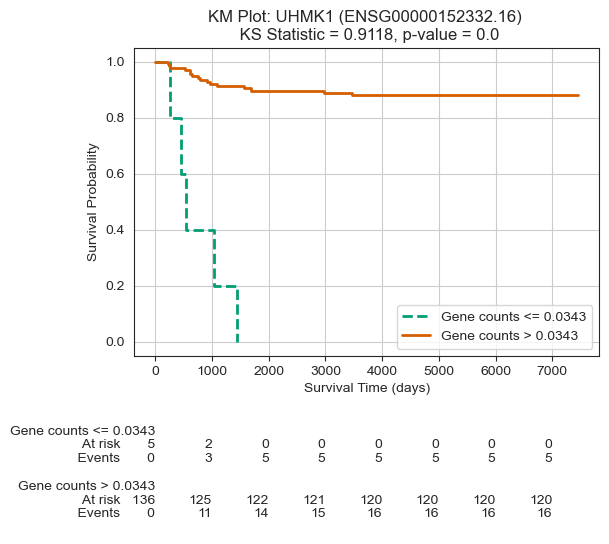

In [1232]:
plot_km(gene_list_Basal[:5], filtered_df, subtype)

### Normal-like

In [1233]:
# Read and sort the result by high ks_statistic
subtype = 'Normal-like'
ks_result = pd.read_csv(f'./result2/ks_{subtype}.csv', sep=',')
ks_result = ks_result[ks_result[f'ks_statistic_{subtype}'] != -np.inf].sort_values(by=f'pvalue_{subtype}')
ks_result

,gene,threshold_Normal-like,pvalue_Normal-like,ks_statistic_Normal-like,size_le,size_he
50769,ENSG00000270755.1,0.000009,0.0002,1.0000,4,21
59977,ENSG00000287580.1,0.000036,0.0009,1.0000,3,22
51459,ENSG00000271870.1,0.000539,0.0009,1.0000,3,22
50206,ENSG00000269696.2,0.000215,0.0009,1.0000,3,22
52270,ENSG00000273338.1,0.000019,0.0009,1.0000,3,22
...,...,...,...,...,...,...
44176,ENSG00000258251.1,NaN,inf,0.5000,6,19
44177,ENSG00000258253.1,NaN,inf,0.5000,6,19
44182,ENSG00000258265.1,NaN,inf,0.2000,20,5
44039,ENSG00000257995.1,NaN,inf,0.1667,24,1


In [1234]:
# Filter result with p-value
filtered_df = ks_result[ks_result[f'pvalue_{subtype}'] <= 0.01]
filtered_df

,gene,threshold_Normal-like,pvalue_Normal-like,ks_statistic_Normal-like,size_le,size_he
50769,ENSG00000270755.1,0.000009,0.0002,1.0,4,21
59977,ENSG00000287580.1,0.000036,0.0009,1.0,3,22
51459,ENSG00000271870.1,0.000539,0.0009,1.0,3,22
50206,ENSG00000269696.2,0.000215,0.0009,1.0,3,22
52270,ENSG00000273338.1,0.000019,0.0009,1.0,3,22
...,...,...,...,...,...,...
52134,ENSG00000273098.3,0.000000,0.0067,1.0,23,2
59045,ENSG00000286628.1,0.000012,0.0067,1.0,23,2
25988,ENSG00000225365.1,0.000044,0.0067,1.0,23,2
25456,ENSG00000224594.2,0.000038,0.0067,1.0,2,23


In [1235]:
# Get top gene lists
gene_list_Normal = filtered_df.iloc[:, 0].to_list()
len(gene_list_Normal)

155

In [1236]:
# Calculate bootstrap p-value for top genes
km_df = filtered_df.copy()
num_simulation = 5000
for gene in gene_list_Normal:
    ks_obs = filtered_df.loc[filtered_df['gene'] == gene, f'ks_statistic_{subtype}'].iloc[0]
    ks_stats_sim, p_value = bootstrap_test(survival_time, ks_obs, num_simulation, subtype)
    km_df.loc[km_df['gene'] == gene, 'bootstrap_p'] = p_value

In [1237]:
# Filter result with p-value
km_df = km_df[km_df['bootstrap_p'] <= 0.001]
km_df

,gene,threshold_Normal-like,pvalue_Normal-like,ks_statistic_Normal-like,size_le,size_he,bootstrap_p
50769,ENSG00000270755.1,0.000009,0.0002,1.0,4,21,0.0
59977,ENSG00000287580.1,0.000036,0.0009,1.0,3,22,0.0
51459,ENSG00000271870.1,0.000539,0.0009,1.0,3,22,0.0
50206,ENSG00000269696.2,0.000215,0.0009,1.0,3,22,0.0
52270,ENSG00000273338.1,0.000019,0.0009,1.0,3,22,0.0
...,...,...,...,...,...,...,...
52134,ENSG00000273098.3,0.000000,0.0067,1.0,23,2,0.0
59045,ENSG00000286628.1,0.000012,0.0067,1.0,23,2,0.0
25988,ENSG00000225365.1,0.000044,0.0067,1.0,23,2,0.0
25456,ENSG00000224594.2,0.000038,0.0067,1.0,2,23,0.0


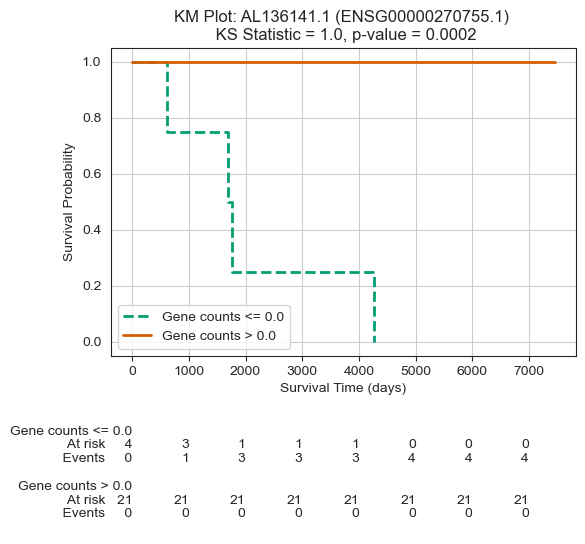

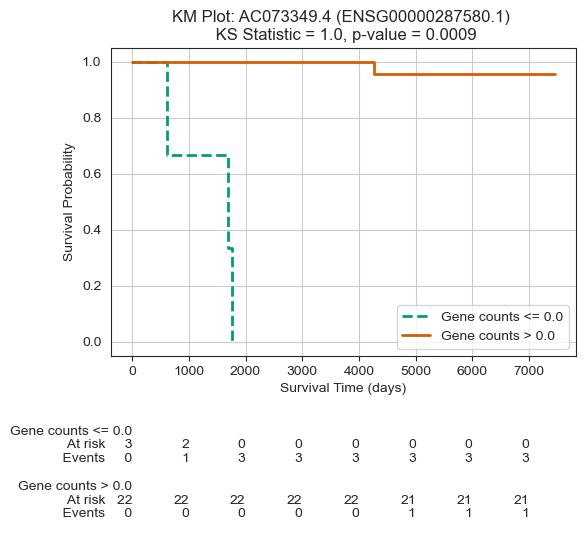

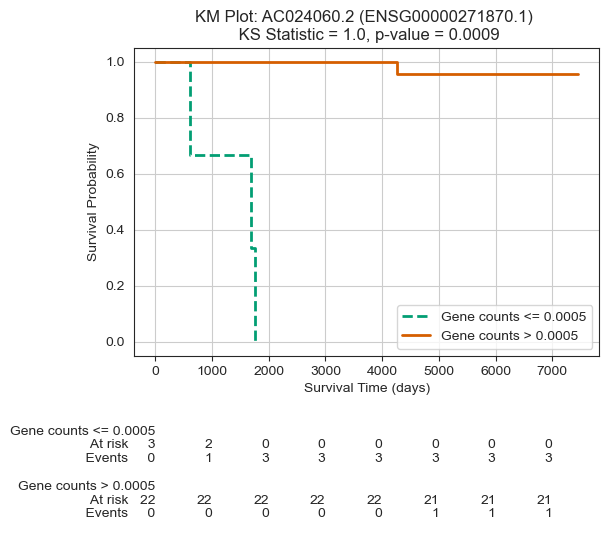

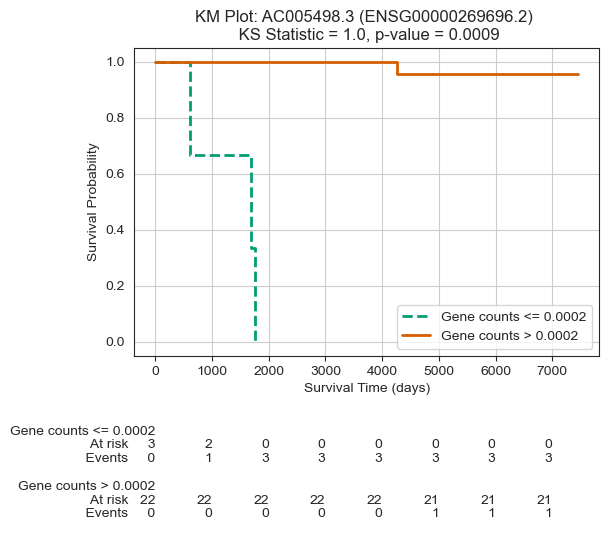

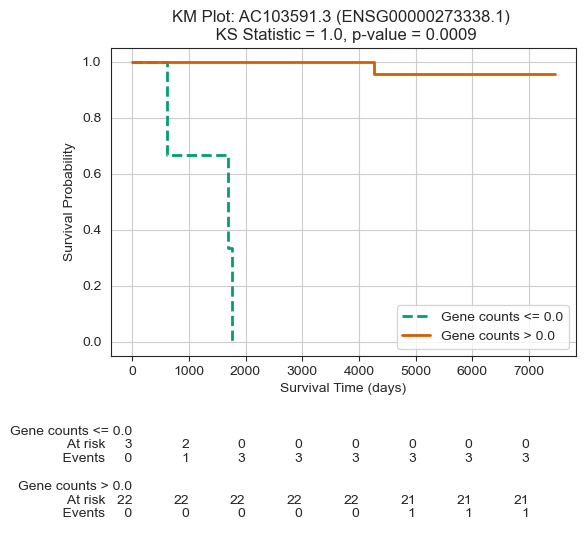

In [1238]:
plot_km(gene_list_Normal[:5], filtered_df, subtype)

### Venn Diagram

<Figure size 1000x1000 with 0 Axes>

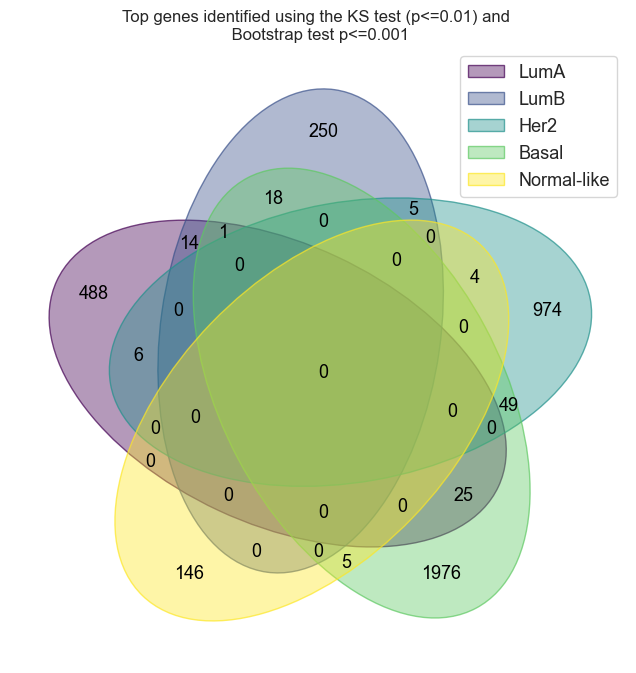

In [1245]:
sets = {
    'LumA': set(gene_list_LumA),
    'LumB': set(gene_list_LumB),
    'Her2': set(gene_list_Her2),
    'Basal': set(gene_list_Basal),
    'Normal-like': set(gene_list_Normal),
}

# Plot the overall Venn diagram for all sets
plt.figure(figsize=(10, 10))
venn(sets)
plt.title('Top genes identified using the KS test (p<=0.01) and \n Bootstrap test p<=0.001')
plt.show()

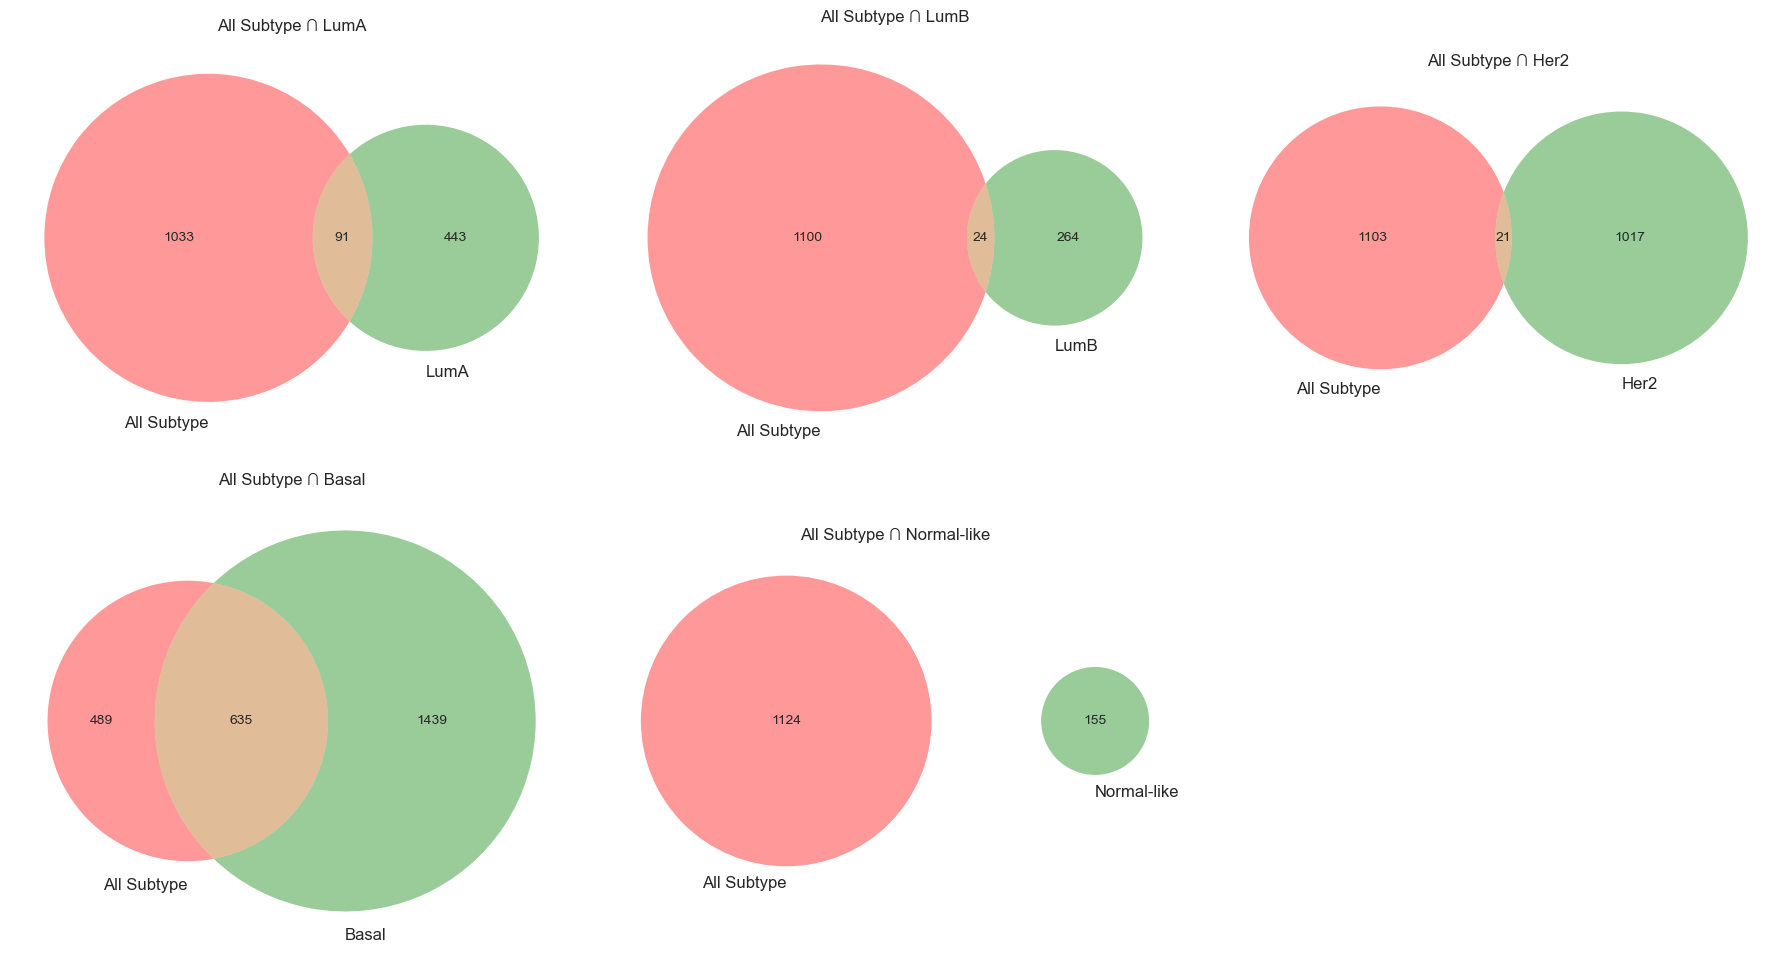

In [1246]:
sets = {
    'All Subtype': set(gene_list_All),
    'LumA': set(gene_list_LumA),
    'LumB': set(gene_list_LumB),
    'Her2': set(gene_list_Her2),
    'Basal': set(gene_list_Basal),
    'Normal-like': set(gene_list_Normal),
}

# Fix 'All Subtype' and compare with the rest
fixed_set_name = 'All Subtype'
fixed_set = sets[fixed_set_name]

# Create a figure with 3x2 subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Flatten axes for easier indexing
axes = axes.flatten()

# Initialize plot index
plot_idx = 0

# Iterate through sets and plot Venn diagrams
for name, current_set in sets.items():
    if name != fixed_set_name:
        # Plot Venn diagram in the respective subplot
        venn2([fixed_set, current_set], set_labels=(fixed_set_name, name), ax=axes[plot_idx])
        axes[plot_idx].set_title(f'{fixed_set_name} ∩ {name}')
        plot_idx += 1

# Hide any remaining empty subplots if there are any
for i in range(plot_idx, len(axes)):
    axes[i].set_visible(False)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [1247]:
for subtype, genes in sets.items():
    print(f"{subtype}: {len(genes)}")

All Subtype: 1124
LumA: 534
LumB: 288
Her2: 1038
Basal: 2074
Normal-like: 155


In [1241]:
# Find the maximum length of the gene sets to align them in columns
max_length = max(len(gene_set) for gene_set in sets.values())

# Create a DataFrame from the sets, padding shorter sets with NaN
df = pd.DataFrame({name: pd.Series(list(gene_set)).reindex(range(max_length)) for name, gene_set in sets.items()})

# Export the DataFrame to a CSV file
df.to_csv('./gene_sets_ks.csv', index=False)

{'ENSG00000168393.13', 'ENSG00000260924.2', 'ENSG00000237575.4'}
{'ENSG00000186501.14'}
set()
set()
set()
set()


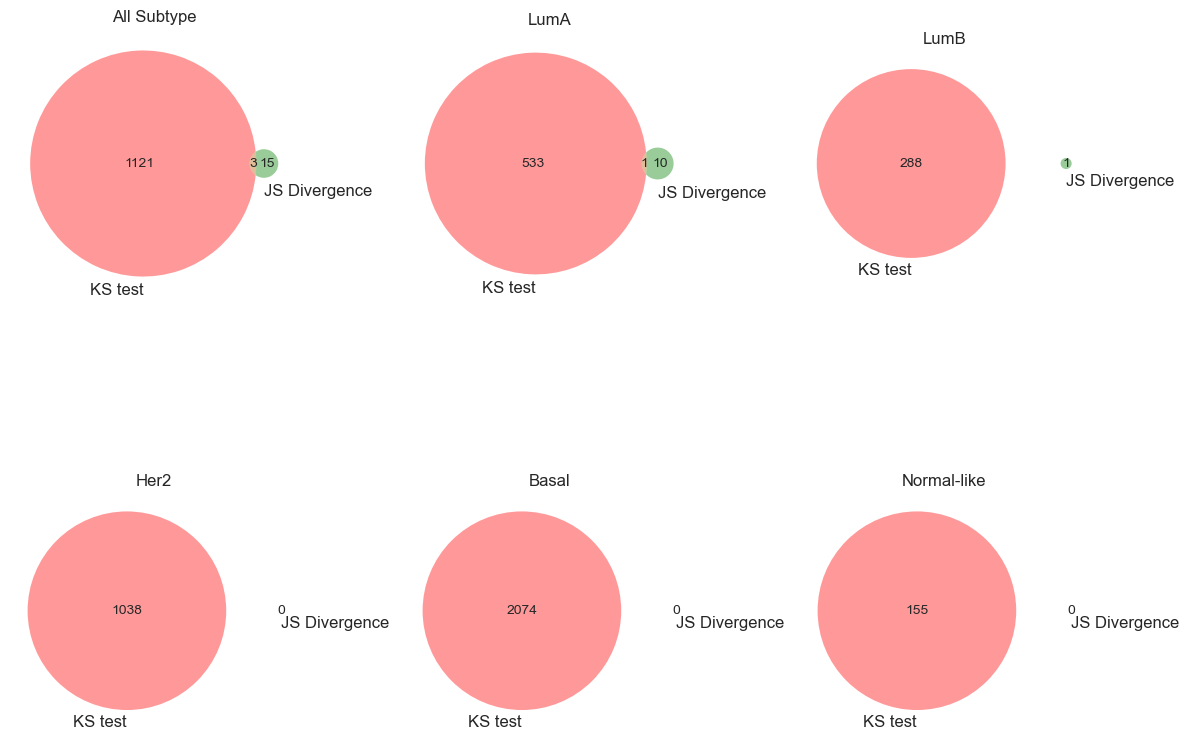

In [1250]:
# Load the two CSV files
df1 = pd.read_csv('./gene_sets_ks.csv')
df2 = pd.read_csv('./gene_sets_jsd.csv')

# Define the number of subplots (2 rows, 3 columns for 6 plots)
fig, axes = plt.subplots(2, 3, figsize=(12, 10))
axes = axes.flatten()

# Iterate over columns (assuming both files have the same columns)
for idx, col in enumerate(df1.columns):
    # Convert the columns to sets, ignoring NaN values
    set1 = set(df1[col].dropna())
    set2 = set(df2[col].dropna())
    
    # Find the intersection of the two sets
    intersection = set1.intersection(set2)
    print(intersection)
    
    # Plot Venn diagram for each subtype
    venn2([set1, set2], set_labels=('KS test', 'JS Divergence'), ax=axes[idx])
    axes[idx].set_title(f'{col}')

plt.tight_layout()
plt.show()

In [1251]:
both_test = ['ENSG00000168393.13', 'ENSG00000260924.2', 'ENSG00000237575.4', 'ENSG00000186501.14']
for gene in both_test:
    print(gene_id_to_name.get(gene, gene))

DTYMK
LINC01311
PYY2
TMEM222


### Group similar expression

In [ ]:
gene = 'ENSG00000000419.13'
row = norm_data.loc[gene]
row

764     0.033998
1092    0.014106
742     0.012051
668     0.052486
783     0.014522
          ...   
821     0.017645
942     0.009661
251     0.015049
136     0.023812
173     0.021715
Name: ENSG00000000419.13, Length: 825, dtype: float64

In [ ]:
# Function to find the minimum difference between all expression levels
def find_min_difference(row):
    # Drop duplicate expression levels
    expression_values = row.drop_duplicates().values
    # Calculate pairwise differences
    diffs = np.abs(expression_values[:, None] - expression_values)
    np.fill_diagonal(diffs, np.inf)  # Ignore the diagonal (zero differences)
    return np.min(diffs)

# Function to group by similar expression levels
def group_similar(row, tolerance):  
    # Sort expression data for the specific gene
    gene_expression = row.sort_values()
    # Group similar expression values by rounding to tolerance
    rounding_factor = int(-np.log10(tolerance))
    expression_groups = gene_expression.round(decimals=rounding_factor)
    # Combine sample names with grouped expressions
    grouped_df = pd.DataFrame({'sample': gene_expression.index, 'expression': gene_expression.values, 'expression_group': expression_groups.values})   
    return grouped_df

min_difference = find_min_difference(row)
print(f"Minimum Difference: {min_difference}")

Minimum Difference: 9.999999999975306e-07


In [ ]:
# Define tolerance for grouping similar expression levels
tolerance = min_difference*1.1

df = group_similar(row, tolerance)

# Find min and max expression values from original df
min_val = df['expression'].min()
max_val = df['expression'].max()

# Remove random samples from each group while keeping at least one
balanced_df = df.groupby('expression_group').apply(lambda x: x.sample(n=1))

# Ensure min and max expression levels are not removed
if min_val not in balanced_df['expression'].values:
    min_row = df[df['expression'] == min_val]
    balanced_df = pd.concat([balanced_df, min_row])

if max_val not in balanced_df['expression'].values:
    max_row = df[df['expression'] == max_val]
    balanced_df = pd.concat([balanced_df, max_row])

# Drop the helper columns and reset index
balanced_df = balanced_df.drop(columns=['expression_group']).reset_index(drop=True)
balanced_df

/var/folders/nn/n9lqp7fs1pq402h_v1c984h40000gn/T/ipykernel_33409/435243307.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby('expression_group').apply(lambda x: x.sample(n=1))


,sample,expression
0,398,0.004873
1,633,0.006091
2,174,0.006440
3,137,0.006531
4,578,0.006672
...,...,...
729,891,0.102053
730,412,0.106087
731,451,0.106893
732,781,0.111783


In [ ]:
# Expression levels in original DataFrame
original_expression_levels = set(df['expression'])

# Expression levels in balanced DataFrame
balanced_expression_levels = set(balanced_df['expression'])

# Check for removed rows
merged = pd.merge(df, balanced_df, how='left', indicator=True)
removed_rows = merged[merged['_merge'] == 'left_only']

print("Removed rows:")
print(len(removed_rows))
print(removed_rows[['sample', 'expression']])

Removed rows:
91
     sample  expression
18      614    0.009799
38     1077    0.011393
45      776    0.011628
46      444    0.011635
55      742    0.012051
..      ...         ...
656      58    0.032008
695     144    0.034198
697     318    0.034416
701     443    0.034549
761     427    0.041427

[91 rows x 2 columns]


In [ ]:
 # Summary statistics
print("\nOriginal DataFrame summary statistics:")
print(df['expression'].describe())

print("\nBalanced DataFrame summary statistics:")
print(balanced_df['expression'].describe())


Original DataFrame summary statistics:
count    825.000000
mean       0.025181
std        0.014295
min        0.004873
25%        0.016817
50%        0.022194
75%        0.029968
max        0.207114
Name: expression, dtype: float64

Balanced DataFrame summary statistics:
count    734.000000
mean       0.025726
std        0.014910
min        0.004873
25%        0.016928
50%        0.022751
75%        0.031054
max        0.207114
Name: expression, dtype: float64


/Users/tk/opt/anaconda3/envs/gene/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/tk/opt/anaconda3/envs/gene/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


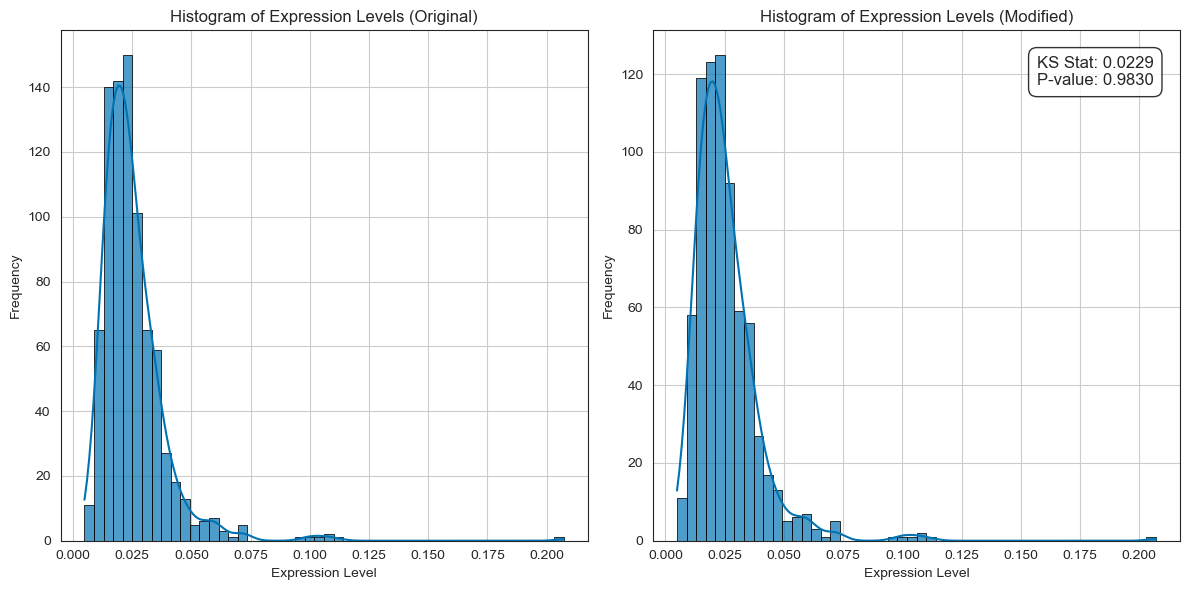

In [ ]:
# Perform KS test
stat, p_value = ks_2samp(df['expression'], balanced_df['expression'])
# print(f"KS Test Statistic: {stat:.4f}, p-value: {p_value:.4f}")

plt.figure(figsize=(12, 6))
# Original distribution histogram
plt.subplot(1, 2, 1)
sns.histplot(df['expression'], bins=50, kde=True, edgecolor='black', alpha=0.7)
plt.title('Histogram of Expression Levels (Original)')
plt.xlabel('Expression Level')
plt.ylabel('Frequency')
plt.grid(True)

# Modified distribution histogram
plt.subplot(1, 2, 2)
sns.histplot(balanced_df['expression'], bins=50, kde=True, edgecolor='black', alpha=0.7)
plt.title('Histogram of Expression Levels (Modified)')
plt.xlabel('Expression Level')
plt.ylabel('Frequency')
plt.grid(True)
plt.text(0.95, 0.95, f'KS Stat: {stat:.4f}\nP-value: {p_value:.4f}',
         horizontalalignment='right',
         verticalalignment='top',
         transform=plt.gca().transAxes,
         fontsize=12,
         bbox=dict(facecolor='white', edgecolor='black', alpha=0.8, boxstyle='round,pad=0.5'))
plt.tight_layout()
plt.show()

In [ ]:
gene_list = ['ENSG00000280670.3',
 'ENSG00000204264.12',
 'ENSG00000100219.16',
 'ENSG00000260924.2',
 'ENSG00000271550.1',
 'ENSG00000100503.26',
 'ENSG00000251411.1',
 'ENSG00000071859.15',
 'ENSG00000258910.3',
 'ENSG00000233203.6']
min_group_size = 1
results = []

for gene in gene_list:
    
    row = norm_data.loc[gene]

    # Find the minimum difference and define the tolerance for grouping
    min_difference = find_min_difference(row)
    tolerance = min_difference * 1.1

    # Group similar expression levels
    df = group_similar(row, tolerance)

    # Find the min and max expression values
    min_val, max_val = df['expression'].min(), df['expression'].max()

    # Balance the DataFrame by sampling one row per group)
    balanced_df = df.groupby('expression_group').apply(lambda x: x.sample(n=1))

    # Ensure min and max expression levels are not removed
    if min_val not in balanced_df['expression'].values:
        min_row = df[df['expression'] == min_val]
        balanced_df = pd.concat([balanced_df, min_row])

    if max_val not in balanced_df['expression'].values:
        max_row = df[df['expression'] == max_val]
        balanced_df = pd.concat([balanced_df, max_row])

    # Drop helper column and reset index
    balanced_df = balanced_df.drop(columns=['expression_group']).reset_index(drop=True)
    print(balanced_df.shape)

    # Transpose the DataFrame
    test = balanced_df.set_index('sample').T
    test.columns = test.columns.astype(int)
    test.reset_index(drop=True, inplace=True)
    columns_array = test.columns.to_numpy()
    test_array = test.values.ravel()
            
    # Initialize variables
    optimal_threshold = None
    lowest_pval = float('inf')
    highest_ks = float('-inf')
    size_le = None
    size_he = None
    
    # Loop through each value in the row to find the optimal threshold
    for threshold in test_array:
        
        le_mask = test_array <= threshold
        gt_mask = test_array > threshold

        # Extract column indices for each group
        group1_col = columns_array[le_mask]
        group2_col = columns_array[gt_mask]
        
        if len(group1_col) >= min_group_size and len(group2_col) >= min_group_size:
        
            # Extract the survival time where index matches the column names
            time_group1 = [key_to_time.get(key) for key in group1_col]
            time_group2 = [key_to_time.get(key) for key in group2_col]

            # Perform KS test
            ks_test = ks_2samp(np.array(time_group1), np.array(time_group2))
            ks_stat = round(ks_test.statistic, 4)
            ks_pval = round(ks_test.pvalue, 4)

            # Check if this p-value is the lowest
            if ks_pval < lowest_pval:
                highest_ks = ks_stat
                lowest_pval = ks_pval
                optimal_threshold = threshold
                size_le = len(time_group1)
                size_he = len(time_group2)

    # Store the results in the dictionary
    results.append({
        'gene': gene,
        'threshold': optimal_threshold,
        'pvalue': lowest_pval,
        'ks_statistic': highest_ks,
        'size_le': size_le,
        'size_he': size_he
    })

# Convert the results to a DataFrame
results_df = pd.DataFrame(results)
results_df

/var/folders/nn/n9lqp7fs1pq402h_v1c984h40000gn/T/ipykernel_33409/3487654553.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby('expression_group').apply(lambda x: x.sample(n=1))
/var/folders/nn/n9lqp7fs1pq402h_v1c984h40000gn/T/ipykernel_33409/3487654553.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby('expression_group').apply(lambda x: x.sample(n=1))


(403, 2)
(784, 2)


/var/folders/nn/n9lqp7fs1pq402h_v1c984h40000gn/T/ipykernel_33409/3487654553.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby('expression_group').apply(lambda x: x.sample(n=1))


(824, 2)


/var/folders/nn/n9lqp7fs1pq402h_v1c984h40000gn/T/ipykernel_33409/3487654553.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby('expression_group').apply(lambda x: x.sample(n=1))
/var/folders/nn/n9lqp7fs1pq402h_v1c984h40000gn/T/ipykernel_33409/3487654553.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby('expression_group').apply(lambda x: x.sample(n=1))


(128, 2)
(213, 2)
(775, 2)


/var/folders/nn/n9lqp7fs1pq402h_v1c984h40000gn/T/ipykernel_33409/3487654553.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby('expression_group').apply(lambda x: x.sample(n=1))
/var/folders/nn/n9lqp7fs1pq402h_v1c984h40000gn/T/ipykernel_33409/3487654553.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby('expression_group').apply(lambda x: x.sample(n=1))


(75, 2)
(775, 2)
(187, 2)
(79, 2)


/var/folders/nn/n9lqp7fs1pq402h_v1c984h40000gn/T/ipykernel_33409/3487654553.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby('expression_group').apply(lambda x: x.sample(n=1))
/var/folders/nn/n9lqp7fs1pq402h_v1c984h40000gn/T/ipykernel_33409/3487654553.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby('expression_group').apply(lambda x: x.sample(n=1))


,gene,threshold,pvalue,ks_statistic,size_le,size_he
0,ENSG00000280670.3,0.000437,0.0132,0.4613,11,392
1,ENSG00000204264.12,0.007327,0.0015,0.5051,13,771
2,ENSG00000100219.16,0.046318,0.0024,0.4891,13,811
3,ENSG00000260924.2,0.000043,0.4299,0.4113,4,124
4,ENSG00000271550.1,0.000062,0.0066,0.6990,5,208
5,ENSG00000100503.26,0.010694,0.0006,0.4631,18,757
6,ENSG00000251411.1,0.000009,0.0043,0.9726,2,73
7,ENSG00000071859.15,0.008904,0.0037,0.4584,14,761
8,ENSG00000258910.3,0.012926,0.0057,0.4558,173,14
9,ENSG00000233203.6,0.000011,0.0097,0.9481,2,77


In [ ]:
# Function to find the minimum difference between all expression levels
def find_min_difference(expression_values):
    # Vectorized computation of absolute differences using NumPy
    diffs = np.abs(expression_values.values[:, None] - expression_values.values)
    np.fill_diagonal(diffs, np.inf)  # Ignore the diagonal (self-differences)
    min_diff = np.min(diffs) if diffs.size else np.nan
    return min_diff

# Function to group by similar expression levels
def group_similar(gene_expression, tolerance):
    # Convert to DataFrame and sort by expression values in a single step
    gene_expression_df = pd.DataFrame({'sample': gene_expression.index, 'expression': gene_expression.values})
    gene_expression_df['expression_group'] = np.round(gene_expression_df['expression'] / tolerance) * tolerance
    return gene_expression_df

gene = 'ENSG00000134905.17'
row = norm_data.loc[gene].drop_duplicates()

# Find the minimum difference and define the tolerance for grouping
min_difference = find_min_difference(row)
tolerance = min_difference * 1.1

# Group similar expression levels
df = group_similar(row, tolerance)

# Find the min and max expression values
min_val, max_val = df['expression'].min(), df['expression'].max()

# Balance the DataFrame by sampling one row per group
balanced_df = df.groupby('expression_group', group_keys=False).apply(lambda x: x.sample(n=1))

# Ensure min and max expression levels are not removed
balanced_df = pd.concat([balanced_df, df[df['expression'].isin([min_val, max_val])]])

# Drop helper column and reset index
balanced_df = balanced_df.drop(columns=['expression_group']).reset_index(drop=True)

# Transpose the DataFrame and adjust column names
test = balanced_df.set_index('sample').T
test.columns = test.columns.astype(int)
test.reset_index(drop=True, inplace=True)
columns_array = test.columns.to_numpy()
test_array = test.values.ravel()
test

/var/folders/nn/n9lqp7fs1pq402h_v1c984h40000gn/T/ipykernel_33409/2093315112.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby('expression_group', group_keys=False).apply(lambda x: x.sample(n=1))


sample,1065,490,120,135,208,776,137,669,829,880,...,1073,848,1047,997,470,417,394,600,1065,600
0,0.005978,0.006209,0.006887,0.006999,0.007119,0.007358,0.007458,0.007774,0.00809,0.008124,...,0.086994,0.087832,0.088443,0.089366,0.093934,0.096471,0.103303,0.17744,0.005978,0.17744


In [ ]:
test_array

array([0.005978, 0.006209, 0.006887, 0.006999, 0.007119, 0.007358,
       0.007458, 0.007774, 0.00809 , 0.008124, 0.008187, 0.00824 ,
       0.008377, 0.009141, 0.009181, 0.00928 , 0.00955 , 0.009604,
       0.009722, 0.009954, 0.009965, 0.009985, 0.010048, 0.010159,
       0.010407, 0.010453, 0.010465, 0.010551, 0.010606, 0.010736,
       0.010738, 0.010833, 0.011015, 0.011082, 0.011178, 0.01124 ,
       0.011373, 0.011392, 0.011401, 0.011436, 0.011461, 0.01148 ,
       0.011582, 0.01173 , 0.011793, 0.011859, 0.011903, 0.011922,
       0.011947, 0.011956, 0.011967, 0.011971, 0.012019, 0.012082,
       0.012108, 0.012183, 0.012251, 0.012303, 0.012323, 0.01239 ,
       0.012503, 0.012564, 0.012592, 0.012603, 0.012607, 0.01262 ,
       0.012638, 0.012706, 0.012753, 0.012758, 0.012885, 0.012887,
       0.012891, 0.012946, 0.012993, 0.013005, 0.013011, 0.013026,
       0.013035, 0.013069, 0.013075, 0.013206, 0.013228, 0.013417,
       0.013418, 0.013426, 0.013445, 0.013461, 0.013514, 0.013

In [ ]:
# Function to find the minimum difference between all expression levels
def find_min_difference(expression_values):
    # Vectorized computation of absolute differences using NumPy
    diffs = np.abs(expression_values.values[:, None] - expression_values.values)
    np.fill_diagonal(diffs, np.inf)  # Ignore the diagonal (self-differences)
    min_diff = np.min(diffs) if diffs.size else np.nan
    return min_diff

# Function to group by similar expression levels
def group_similar(gene_expression, tolerance):
    # Convert to DataFrame and sort by expression values in a single step
    gene_expression_df = pd.DataFrame({'sample': gene_expression.index, 'expression': gene_expression.values})
    gene_expression_df['expression_group'] = np.round(gene_expression_df['expression'] / tolerance) * tolerance
    return gene_expression_df

####
# Input
gene = 'ENSG00000134905.17'
row = norm_data.loc[gene].drop_duplicates()

# Find the minimum difference and define the tolerance for grouping
min_difference = find_min_difference(row)
tolerance = min_difference * 1.1

# Group similar expression levels
df = group_similar(row, tolerance)

# Find the min and max expression values
min_val, max_val = df['expression'].min(), df['expression'].max()

# Balance the DataFrame by sampling one row per group
balanced_df = df.groupby('expression_group', group_keys=False).apply(lambda x: x.sample(n=1))

# Ensure min and max expression levels are not removed
balanced_df = pd.concat([balanced_df, df[df['expression'].isin([min_val, max_val])]])

# Drop helper column and reset index
balanced_df = balanced_df.drop(columns=['expression_group']).reset_index(drop=True)

# Transpose the DataFrame and adjust column names
test = balanced_df.set_index('sample').T
test.columns = test.columns.astype(int)
test.reset_index(drop=True, inplace=True)

test

/var/folders/nn/n9lqp7fs1pq402h_v1c984h40000gn/T/ipykernel_33409/3572837735.py:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby('expression_group', group_keys=False).apply(lambda x: x.sample(n=1))


sample,1065,490,120,135,208,776,137,669,829,880,...,1073,848,1047,997,470,417,394,600,1065,600
0,0.005978,0.006209,0.006887,0.006999,0.007119,0.007358,0.007458,0.007774,0.00809,0.008124,...,0.086994,0.087832,0.088443,0.089366,0.093934,0.096471,0.103303,0.17744,0.005978,0.17744


In [ ]:
# Convert DataFrame to a NumPy array
test_array = test.to_numpy().ravel()
test_array

array([0.005978, 0.006209, 0.006887, 0.006999, 0.007119, 0.007358,
       0.007458, 0.007774, 0.00809 , 0.008124, 0.008187, 0.00824 ,
       0.008377, 0.009141, 0.009181, 0.00928 , 0.00955 , 0.009604,
       0.009722, 0.009954, 0.009965, 0.009985, 0.010048, 0.010159,
       0.010407, 0.010453, 0.010465, 0.010551, 0.010606, 0.010736,
       0.010738, 0.010833, 0.011015, 0.011082, 0.011178, 0.01124 ,
       0.011373, 0.011392, 0.011401, 0.011436, 0.011461, 0.01148 ,
       0.011582, 0.01173 , 0.011793, 0.011859, 0.011903, 0.011922,
       0.011947, 0.011956, 0.011967, 0.011971, 0.012019, 0.012082,
       0.012108, 0.012183, 0.012251, 0.012303, 0.012323, 0.01239 ,
       0.012503, 0.012564, 0.012592, 0.012603, 0.012607, 0.01262 ,
       0.012638, 0.012706, 0.012753, 0.012758, 0.012885, 0.012887,
       0.012891, 0.012946, 0.012993, 0.013005, 0.013011, 0.013026,
       0.013035, 0.013069, 0.013075, 0.013206, 0.013228, 0.013417,
       0.013418, 0.013426, 0.013445, 0.013461, 0.013514, 0.013

In [ ]:
from scipy.stats import ks_2samp

# Convert to array
data = norm_data.values
columns_array = norm_data.columns.to_numpy()

gene_list = gene_id[:1]
min_group_size = 1
results = []

for gene in gene_list:
    
    # Get the index for the gene
    gene_idx = gene_to_index[gene]

    # Get the row where index = gene
    row = data[gene_idx]
    
    # Initialize variables
    optimal_threshold = None
    lowest_pval = float('inf')
    highest_ks = float('-inf')
    size_le = None
    size_he = None
    
    # Loop through each value in the row to find the optimal threshold
    for threshold in row:
        
        le_mask = row <= threshold
        gt_mask = row > threshold

        # Extract column indices for each group
        group1_col = columns_array[le_mask]
        group2_col = columns_array[gt_mask]
        
        if len(group1_col) >= min_group_size and len(group2_col) >= min_group_size:
        
            # Extract the survival time where index matches the column names
            time_group1 = [key_to_time.get(key) for key in group1_col]
            time_group2 = [key_to_time.get(key) for key in group2_col]

            # Perform KS test
            ks_test = ks_2samp(np.array(time_group1), np.array(time_group2))
            ks_stat = round(ks_test.statistic, 4)
            ks_pval = round(ks_test.pvalue, 4)

            # Check if this p-value is the lowest
            if ks_pval < lowest_pval:
                highest_ks = ks_stat
                lowest_pval = ks_pval
                optimal_threshold = threshold
                size_le = len(time_group1)
                size_he = len(time_group2)

    # Store the results in the dictionary
    results.append({
        'gene': gene,
        'threshold': optimal_threshold,
        'pvalue': lowest_pval,
        'ks_statistic': highest_ks,
        'size_le': size_le,
        'size_he': size_he
    })

# Convert the results to a DataFrame
results_df = pd.DataFrame(results)
results_df

,gene,threshold,pvalue,ks_statistic,size_le,size_he
0,ENSG00000000003.15,0.014024,0.4321,0.0733,172,653
1,ENSG00000000005.6,0.000025,0.5868,0.0640,180,645


In [440]:
from lifelines.statistics import logrank_test, multivariate_logrank_test

def plot_km(gene_list, result_df, subtype):
    for gene in gene_list:
        # Get gene count
        row = pd.to_numeric(norm_count.loc[gene].values, errors='coerce')

        # Get optimal threshold for that gene
        tbl = result_df[result_df['gene'] == gene]
        optimal_threshold = pd.to_numeric(tbl[f'threshold_{subtype}'].values[0], errors='coerce')
        
        # Subtype masking
        mask = (subtypes == subtype)
        time = survival_time[mask]
        event = status[mask]
        count = row[mask]
        
        # Split time, status based on current threshold
        time_g1 = time[count <= optimal_threshold]
        time_g2 = time[count > optimal_threshold]
        status_g1 = event[count <= optimal_threshold]
        status_g2 = event[count > optimal_threshold]

        # Perform KS test
        if len(time_g1) >= 1 and len(time_g2) >= 1:
            ks_test = ks_2samp(time_g1, time_g2) 
            ks_stat = round(ks_test.statistic, 4)
            ks_pval = round(ks_test.pvalue, 4)

        # Fit KaplanMeierFitter
        _, ax = plt.subplots(figsize=(6, 4))
        kmf_1 = KaplanMeierFitter()
        kmf_2 = KaplanMeierFitter()
        kmf_1.fit(time_g1, status_g1, label=f"Gene counts <= {round(optimal_threshold, 4)}")
        kmf_2.fit(time_g2, status_g2, label=f"Gene counts > {round(optimal_threshold, 4)}")

        kmf_1.plot_survival_function(ax=ax, ci_show=False, linestyle='dashed', linewidth=2, color=sns.color_palette('colorblind')[2])
        kmf_2.plot_survival_function(ax=ax, ci_show=False, linestyle='solid', linewidth=2, color=sns.color_palette('colorblind')[3])
        add_at_risk_counts(kmf_1, kmf_2, ax=ax, rows_to_show=['At risk', 'Events'])

        # Perform Log-rank test
        logrank_results = logrank_test(time_g1, time_g2, event_observed_A=status_g1, event_observed_B=status_g2)
        plt.text(0.7, 0.5, f'Log-rank p-value: {logrank_results.p_value:.4f}', transform=ax.transAxes)

        # Perform Wilcoxon (Gehan-Breslow) test
        # wilcoxon_results = multivariate_logrank_test(df['time'], df['group'], df['event'], weightings="wilcoxon")

        text = f"KS Statistic = {ks_stat}, p-value = {ks_pval}"
        ax.set_title(f"KM Plot: {gene_id_to_name.get(gene, gene)} ({gene}) \n {text}")
        ax.set_xlabel("Survival Time (days)")
        ax.set_ylabel("Survival Probability")
        ax.grid()
        ax.legend();

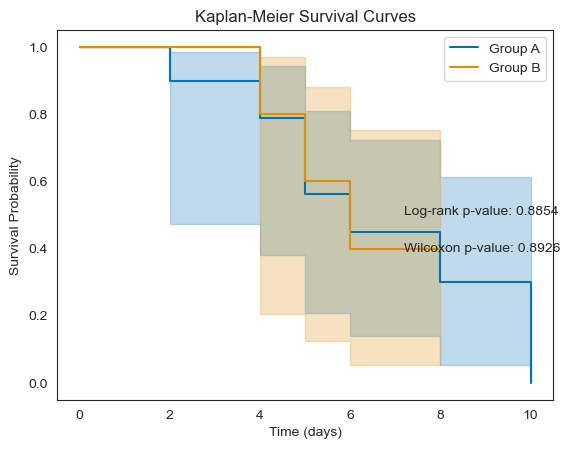

In [439]:
import pandas as pd
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test, multivariate_logrank_test
import matplotlib.pyplot as plt

# Example dataset
data = {
    'time': [5, 6, 6, 2, 4, 3, 5, 8, 9, 10, 4, 5, 7, 6, 8],
    'event': [1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0],  # 1 = death, 0 = censored
    'group': ['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'B']  # Group A vs B
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Split data into two groups
group_A = df[df['group'] == 'A']
group_B = df[df['group'] == 'B']

# Kaplan-Meier estimator for each group
kmf_A = KaplanMeierFitter()
kmf_B = KaplanMeierFitter()

# Fit the models
kmf_A.fit(group_A['time'], event_observed=group_A['event'], label='Group A')
kmf_B.fit(group_B['time'], event_observed=group_B['event'], label='Group B')

# Plot the survival curves
ax = kmf_A.plot_survival_function()
kmf_B.plot_survival_function(ax=ax)
plt.title('Kaplan-Meier Survival Curves')
plt.xlabel('Time (days)')
plt.ylabel('Survival Probability')

# Perform Log-rank test
logrank_results = logrank_test(group_A['time'], group_B['time'], event_observed_A=group_A['event'], event_observed_B=group_B['event'])

# Perform Wilcoxon (Gehan-Breslow) test
wilcoxon_results = multivariate_logrank_test(df['time'], df['group'], df['event'], weightings="wilcoxon")

# Example: Adding a third test result manually (you can replace this with another test result)
# Here, we'll assume a third test for illustration purposes
# third_test_p_value = 0.08  # Example p-value for a third test

# Add p-values as text to the plot
plt.text(0.7, 0.5, f'Log-rank p-value: {logrank_results.p_value:.4f}', transform=ax.transAxes)
plt.text(0.7, 0.4, f'Wilcoxon p-value: {wilcoxon_results.p_value:.4f}', transform=ax.transAxes)
# plt.text(0.7, 0.3, f'Third Test p-value: {third_test_p_value:.4f}', transform=ax.transAxes)

# Show the plot
plt.show()

/Users/tk/opt/anaconda3/envs/gene/lib/python3.10/site-packages/lifelines/fitters/coxph_fitter.py:1589: ConvergenceWarning: The log-likelihood is getting suspiciously close to 0 and the delta is still large. There may be complete separation in the dataset. This may result in incorrect inference of coefficients. See https://stats.stackexchange.com/q/11109/11867 for more.

  warnings.warn(
/Users/tk/opt/anaconda3/envs/gene/lib/python3.10/site-packages/lifelines/fitters/coxph_fitter.py:1614: ConvergenceWarning: Newton-Raphson failed to converge sufficiently. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
  warnings.warn(


<lifelines.CoxPHFitter: fitted with 5 total observations, 2 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 5
number of events observed = 3
   partial log-likelihood = -0.00
         time fit was run = 2024-10-02 02:06:22 UTC

---
            coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                   
feature_1  -1.20      0.30     18.52          -37.49           35.10                0.00            1.76e+15
feature_2  10.38  32128.70    308.66         -594.59          615.34                0.00           1.74e+267
feature_3 -47.43      0.00    679.87        -1379.96         1285.10                0.00                 inf

           cmp to     z    p  -log2(p)
covariate                             
feature_1    0.00 -0.06 0.95      0.08
feature_2    0.00  0.03 0.97      0.04
feature_3    0.00 -0.07 0.94      0.08
---
Concordance = 1.00
Partial AIC = 6.00
log-likelihood ratio test = 5.42 on 3 df
-log2(p) of ll-ratio test = 2.80

<Axes: xlabel='log(HR) (95% CI)'>

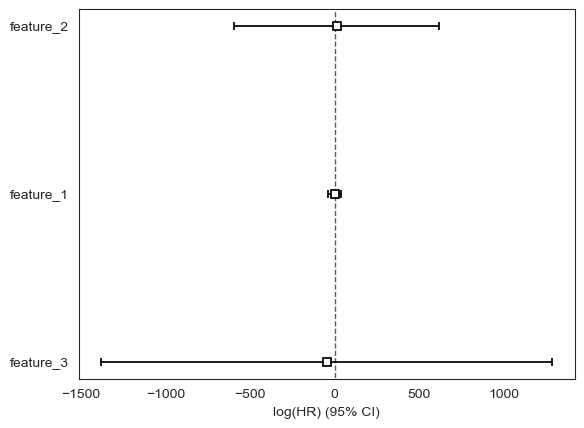

In [470]:
import pandas as pd
from lifelines import CoxPHFitter

# Example data: Replace this with your real dataset
data = pd.DataFrame({
    'time': [34, 45, 60, 76, 89],  # Time to event or censoring
    'event': [1, 0, 1, 0, 1],      # 1 = Event occurred, 0 = Censored
    'feature_1': [56.2, 63.7, 52.9, 70.1, 68.9],
    'feature_2': [1, 0, 1, 1, 0],
    'feature_3': [0.25, 0.45, 0.55, 0.35, 0.15],
    # ... include all your 10 features here
})

# Instantiate the Cox Proportional Hazards model
cph = CoxPHFitter()

# Fit the model to your data
cph.fit(data, duration_col='time', event_col='event')

# Print a summary of the model
cph.print_summary()

# Optionally, you can plot the coefficients:
cph.plot()

In [471]:
import pandas as pd
from lifelines import CoxTimeVaryingFitter

# Example of time-varying covariate data
# id: unique identifier for each subject
# start: start of the time interval
# stop: end of the time interval
# event: 1 if event (e.g., death) occurred in this interval, 0 if censored
# feature_1, feature_2, ..., feature_10: covariates (some might change over time)

data = pd.DataFrame({
    'id': [1, 1, 2, 2, 3, 3],  # unique subject identifiers
    'start': [0, 10, 0, 15, 0, 7],  # start of the interval
    'stop': [10, 20, 15, 30, 7, 20],  # end of the interval
    'event': [0, 1, 0, 1, 0, 1],  # event indicator (1 = event, 0 = censored)
    'feature_1': [56.2, 57.3, 45.6, 46.8, 60.5, 61.2],  # example time-varying feature
    'feature_2': [1, 1, 0, 0, 1, 1],  # another feature (could be constant or varying)
    'feature_3': [0.25, 0.30, 0.35, 0.40, 0.55, 0.60],
    # Add feature_4 to feature_10 similarly
})

# Initialize the Cox Time-Varying model
ctv = CoxTimeVaryingFitter()

# Fit the model
ctv.fit(data, id_col='id', start_col='start', stop_col='stop', event_col='event')

# Print the summary of the fitted model
ctv.print_summary()

# Optionally, plot the estimated coefficients
ctv.plot()


LinAlgError: Matrix is singular.